# import libraries

In [713]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from scipy.ndimage import gaussian_filter

#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess2nd as lp
import imp
imp.reload(lp)

<module 'LammpsPostProcess2nd' from '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/LammpsPostProcess2nd.py'>

In [3]:
#matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!

# utility functions

In [672]:
def CrssCrltn(x,y):        
    x-=np.mean(x)
    x/=np.std(x)

    y-=np.mean(y)
    y/=np.std(y)

    return (np.sum(x*y)/len(x))


def ScatterXY( vor, d2min,
                  Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
                 axisLabels = True,
                 **kwargs,
               
                ):

            #

    #--- cross crltn.
    x = np.array(vor.tmp)
    y = np.array(d2min.tmp)
    #---

    y=y[x>0]
    x=x[x>0]

    crs = CrssCrltn( np.log10(x.copy()), np.log10(y.copy()) )
        
    if Plot:
        #--- plot
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.scatter(x,y,marker='x',alpha=0.08)
        #
        if PLOT_AVERAGE:
            xb, yb, err_x, err_y = GetBinnedAverage( np.log10(x), np.log10(y), nbins_per_decade = 8 )
            nevery = int(np.ceil(len(xb)/10.0))
            ax.errorbar(x=10**xb,y=10**yb,yerr=10**yb*err_y,xerr=10**xb*err_x,
                fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
                        markeredgecolor='red', markevery=nevery, errorevery=nevery,
                linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)
#                 def func(x,a,b):
#                     return a*x+b
#                 z = np.polyfit(xb, yb, 1)

#                 label = r'$%2.1e.x+%2.1e$'%(z[0],z[1])
            
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
#        makeTickLabels(ax, x, y)
        #
        ax.set_yscale('log')
        ax.set_xscale('log')
        #
        if 'axisLabels' in kwargs:
            (xlabel, ylabel) = kwargs['axisLabels']
            ax.set_ylabel(ylabel,fontsize=16)
            ax.set_xlabel(xlabel,fontsize=16)
            #
            ax.set_title(r'cxy=%3.2e'%crs,fontsize=16)
            #
#        ax.legend(frameon=False, fontsize=12)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_X=True,LOG_Y=True) 
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()


def GetFullIcosahedra( vor ):
    dff=pd.DataFrame(vor.__dict__)
    indices = np.all([  dff['VoronoiIndex1']==0.0,dff['VoronoiIndex2']==0.0,dff['VoronoiIndex3']==0.0,\
                    dff['VoronoiIndex4']==0.0,dff['VoronoiIndex5']==12.0,dff['VoronoiIndex6']==0.0,\
                    dff['VoronoiIndex7']==0.0,dff['VoronoiIndex8']==0.0,dff['VoronoiIndex9']==0.0],axis=0)
#     indices = np.all([  dff['VoronoiIndex3']==0.0,dff['VoronoiIndex4']==0.0,dff['VoronoiIndex5']==12.0,\
#                     dff['VoronoiIndex6']==0.0],axis=0)
#    pdb.set_trace()
#    vor_df = pd.DataFrame(vor.__dict__)
        
#    df = pd.DataFrame(np.concatenate((np.c_[vor_df], np.c_[indices]), axis=1, dtype=np.object),
#                      columns=list(vor_df.keys())+['IcoTrue'])

    return indices #lp.Atoms(**df.to_dict(orient='series'))


def Get2dSlice( value, zlin, zc, nzll=[0] ):
        #--- get xy plane
#    zc=0.5*(zlin[0]+zlin[-1])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nz = len(zlin)
    #
    zz = zc #zlin[-1] #zc #zlin[-1] #--- arbitrary plane
    nzz=int(nz*(zz-zlin[0])/lz)
    print(nzz,nz)
    if nzz == nz: nzz -= 1
    val = value[:,:,nzz].copy()
    #
    nzll[0] = nzz
    return val

def Get2dSliceScattered( xm, ym, zm, 
                        zlin, zc ):    
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nz = len(zlin)
    dz *= 2.0
    zz=zc
    #
    zlo=(zz-dz-zlin[0]) % lz + zlin[0]
    zhi=(zz+dz-zlin[0]) % lz + zlin[0]
    indxx= np.all([zm > zlo, 
                   zm < zhi
                  ],
                    axis=0)
    if zhi < zlo: #--- periodic boundaries
        indxx= np.any([zm > zlo, 
           zm < zhi
          ],
            axis=0)
    return np.c_[xm,ym][indxx]        
    
def GetInterpolatedData( x,y,z, 
                         xv, yv, zv,
                       ):
    r2nd=4.8 #--- g(r)
    dx = xv[1]-xv[0]
    dy = yv[1]-yv[0]
    dz = zv[1]-zv[0]
    dr = (dx*dx+dy*dy+dz*dz)**0.5
    sigma = int(r2nd/dr)
    heatmap, edges = np.histogramdd( np.c_[y, x, z],
                                    bins=[np.append(yv,yv[-1]+dy),
                                          np.append(xv,xv[-1]+dx),
                                          np.append(zv,zv[-1]+dz)],
                                    normed=True)

    print('(nx,ny,nz)=', heatmap.shape )
    
    heatmap *= len( x )
    heatmap = gaussian_filter( heatmap, sigma = sigma )
    return heatmap



def DensityMap(atoms0, filtr, xv, yv,zv):    
    #--- scattered points
    xs = np.array(atoms0.xm)[filtr] #--- must be reference frame!
    ys = np.array(atoms0.ym)[filtr]
    zs = np.array(atoms0.zm)[filtr]

    (nx,ny,nz)=list(map(len,[xv,yv,zv]))
    #--- density
    heatmap=GetInterpolatedData(xs,ys,zs,
                                xv, yv, zv,
                               )
    #--- 2d slice
    heatmap2d = Get2dSlice( heatmap, zv, 
                            zv[-1] )
    #--- plot scattered data
    xy = Get2dSliceScattered( xs, ys, zs, 
                        zv, zv[-1] )
    #--- bitmap
    PltBitmapWithScatter(
          heatmap2d, #transpose? 
          xy,
          xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
          xlim=np.array([xv.min(),xv.max()]),ylim=np.array([yv.min(),yv.max()]),
          zscore = True,
          frac = 1.0, #--- plot a patch
          title = 'kdeRho.png',
          colorbar=True,
          ticklabels = True,
          color='black',
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
          )

    
    return heatmap

def Zscore(val):
    x=val.copy()
    x -= np.mean(x)
    x /= np.std(x)
    return x


def SetTickLabels(ax, **kwargs):
    fmt='%3.1f'
    if 'xaxis' in kwargs:
        tickLabels = kwargs['xaxis']
        ax.xaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.xaxis.set_ticks(tickLabels)
    if 'yaxis' in kwargs:
        tickLabels = kwargs['yaxis']
        ax.yaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.yaxis.set_ticks(tickLabels)
        

 
        
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    
def gaussian_mixture( values, 
                     times,
                     LABELS = False, 
                     PLOT = True):
    thresh = {}
    ratio = {}
#    pdb.set_trace()
    gsFitTotal = 1.0
    for itime in sorted( times ):
    #--- convert data frema to array
        nij = values[itime]
        X=np.log10(nij)
        X=np.array(X).reshape(len(X),1)

        try:
            gm_obj = skm.BayesianGaussianMixture(n_components=2, tol=1e-8, max_iter=10000,
                                                verbose=0, 
    #                                            random_state=32,
    #                                            init_params='random',
                                               )
            gm_obj.fit(X)

            if not gm_obj.converged_:
                continue

            #--- min(\mu0, \mu1) corresponds to trig. mode
            mean0 = gm_obj.means_[0][0]
            mean1 = gm_obj.means_[1][0]
            d     = { 'trigrd':min([mean0,0],[mean1,1])[1], 
                      'backgrd':max([mean0,0],[mean1,1])[1]}
            mean  = { 'trigrd' : gm_obj.means_[d['trigrd']][0],
                      'backgrd': gm_obj.means_[d['backgrd']][0] }
            sigma = { 'trigrd' : gm_obj.covariances_[d['trigrd']][0]**0.5,
                      'backgrd': gm_obj.covariances_[d['backgrd']][0]**0.5 }
            delta = { 'trigrd' : gm_obj.weights_[d['trigrd']],
                      'backgrd': gm_obj.weights_[d['backgrd']] }
    #        print(sigma['backgrd']/mean['backgrd'])
            #--- plot scatter
            nij_red = nij[gm_obj.predict(X)==0]
            nij_blue = nij[gm_obj.predict(X)==1]
            #ratio[itime] =  sigma['backgrd']/mean['backgrd'] #
            ratio[itime] = 1.0 * len(nij_blue) / (len(nij_red)+len(nij_blue))
    #        print(len(nij_red)+len(nij_blue))
    #        prob = np.random.rand(len(X))
    #         list_of_red = prob  <   gm_obj.predict_proba(X)[:, d['trigrd']] #--- assign modes based on the responsibilities \gamma
    #         list_of_blue = prob >= gm_obj.predict_proba(X)[:, d['trigrd']]
    #         nij_red = nij[list_of_red]
    #         nij_blue = nij[list_of_blue]

            #--- plot distributions
            edge_act, hist_act = DistNij(nij,normed=None, nbins_per_decade = 16)

            if PLOT:
                print('itime=%s, ratio=%s'%(itime,ratio[itime]))
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(111)
    #            ax.set_yscale('log')
    #            ax.set_ylim(0.9,len(nij_red))#1e3)
                #
                ax.plot(edge_act,hist_act,'o',color='black',label='Total')
                #
                xv = edge_act
                ax.plot( xv, 
                        len(X)*(delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])+
                                delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd']))*(xv[1]-xv[0]), 
                        color='black')
                ax.plot( xv, len(X)*delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])*(xv[1]-xv[0]),color='red')
                ax.plot( xv, len(X)*delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd'])*(xv[1]-xv[0]),color='C0')
                if LABELS:
                    ax.set_xlabel(r'$log n_{ij}$')
                    ax.set_ylabel(r'$P(log n_{ij})$')
                ax.set_xlim(np.floor(np.min(edge_act)),np.ceil(np.max(edge_act)))
                #
                gsFitTotal = np.c_[ax.get_lines()[1].get_xdata(),ax.get_lines()[1].get_ydata()] #--- return data
            #


            #--- find decision boundary
            mu0,mu1,sigma0,sigma1,delta0,delta1=mean['trigrd'],mean['backgrd'],sigma['trigrd'],sigma['backgrd'],delta['trigrd'],delta['backgrd']
            def f(x): #,:
                return delta0*np.exp(-0.5*((x-mu0)/sigma0)**2)/sigma0 -\
                        delta1*np.exp(-0.5*((x-mu1)/sigma1)**2)/sigma1
            n_th = 0
            try:
                n_th = optimize.bisect(f, mu0-1*sigma0, mu1+1*sigma1)
                if PLOT:
                    ax.plot([n_th,n_th],ax.axis()[2:],'-.r') #--- vertical line
                thresh[itime]=10**n_th
            except:
                traceback.print_exc()
                pass
            if PLOT:
                fig.savefig('distnijGM.png',bbox_inches='tight',dpi=2*75)
                plt.show()

        except:
            traceback.print_exc()
            continue
    #     print gm_obj.predict_proba([[n_th]])
    return thresh, ratio, gsFitTotal

def DistNij(nij,normed=True, nbins_per_decade = 4, **kwargs):
#--- histogram
    nn=np.log10(nij)
    nmin=kwargs['nmin'] if 'nmin' in kwargs else nn.min()
    nmax=kwargs['nmax'] if 'nmax' in kwargs else nn.max()
    bins=np.linspace(nmin,nmax,int(nmax-nmin)*nbins_per_decade)
    hist, edge = np.histogram(nn,bins=bins,normed=normed)
    
    #--- accumulated histogram
    slist=np.array(nn)
    slist.sort()
    N = len(slist)
    d = histogramACCUMLTD( slist.tolist() )
    keys=list(d.keys())
    keys.sort()
    
    xx=[];yy=[]
    for ikey in keys:
        xx.append(d[ikey][0])
        yy.append(d[ikey][2])
    
    # ax2 = ax.twinx()
    # ax2.plot(xx,yy,
    #         linestyle='-', drawstyle='steps-post',color='red',
    #         linewidth=1.0) #--- accumulated
    # #ax2.set_xlim(-7,1)
    # #ax2.set_ylim(0,1200)
    
    # ax2.tick_params(axis='y',colors='red')
    # ax2.set_ylabel('$N(<n_{ij})$',color='red')
    
    return edge[:-1],hist

def valuesDict(d,keys):
    return list(map(d.get,sorted(keys)))


def histogramACCUMLTD( slist ):
    assert type( slist ) == type( [] ), 'arg must be a list. a %s is given!' %( type( slist ) )
    d = {}
    for item in slist:
        try:
            d[ item ] += 1
        except:
            d[ item ] = 1
    keys = list(d.keys())
    keys.sort()

    cdf = 0.0
    xi = min( slist ) - 1.0e-6
    xf = max( slist ) + 1.0e-6
    npoin = len( slist )
    adict = {}
    for ikey, index in zip( keys, range( sys.maxsize ) ):
        adict[ index ] = [ xi, ikey, cdf ]
        cdf += 1.0 * d[ ikey ] # / npoin
        xi = ikey
    adict[ index + 1 ] = [ xi, xf, cdf ]
    return adict

def GetStrain(lmpData, times, time0 ):
    ebulk = {}
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0], AddMissing = np.array([0.0,0.0,0.0] ))
    for itime in times:

        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk[itime] = dx/l1
    return ebulk
        
    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print('column already included!')
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
    
def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.axes.xaxis.set_visible(False) #--- remove labels
    ax.axes.yaxis.set_visible(False)

    pos = ax.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),
                     #,vmin=-.01, vmax=.01
                    )
    ax.set_xlim(xlim[0]*frac,xlim[1]*frac)
    ax.set_ylim(ylim[0]*frac,ylim[1]*frac)

#    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()
    
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[a[i,j] for j in range(-int(ngrid/2),int(ngrid/2)+ngrid%2)] 
                              for i in range(-int(mgrid/2),int(mgrid/2)+mgrid%2)])

def Get_rc( xdata, ydata, cTOL ):
    try:
#        xc1 = xdata[np.abs(ydata)<cTOL][0] 
        xc1 = xdata[ydata<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 xv,yv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 symmetry = True,
                ):
    (ny,nx,nz) = crltn.shape
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
#         ax.set_xlabel(xstr,fontsize=16)
#         ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
        PutMinorTicks(ax)
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    indx0 = 0 if symmetry else -int(n/2)
    rangee = np.arange(indx0,(int(n/2)+n%2))
    xdata0 = rangee * dx
    ydata0 = val[0,rangee]
    #
    xc = Get_rc( xdata0, ydata0, cTOL )
    #
    if PLOT:
        ax.plot( xdata0, ydata0,
                '-o',label=r'$x$',
                markersize=10,
                color='black',
                markerfacecolor='white',
                markeredgecolor=None,
                markevery=int(len(xdata0)/10),
               )       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    indx0 = 0 if symmetry else -int(m/2)
    rangee = np.arange(indx0,(int(m/2)+m%2))
    xdata = rangee * dy
    ydata = val[rangee,0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,
                '-s', 
                color = 'red',
                label=r'$y$',
                markersize=10,
                markerfacecolor=None,
                markeredgecolor='black',
                markevery=int(len(xdata)/10),
               )
    #--- plot
    if PLOT:
        ax.legend(frameon=False, fontsize=20,handletextpad=.4,handlelength=1)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='red')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
#        ax.plot((xc,xc),ax.axis()[2:],'-.r')
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
        #
        plt.savefig(fileName,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return (xc, yc), (xdata0,ydata0), (xdata,ydata) 


def GetSlice2d( hist, err,
         xv, yv, zv,
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         xv, yv,
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc


def DrawFrame(ax, alpha_xl,alpha_xr,alpha_yb,alpha_yt,linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
def MultipleFrames( path='', title='', irun = 0, nmax = 10000 ):
    i=0
    append = False
    while i < nmax:
        try:
            sarr0 = np.c_[np.loadtxt('%s%i/Run%s/%s'%(path,i,irun,title))].T
            #        print i,sarr0
            if not append:
                sarr = sarr0.copy()
                append = True
            else:
                sarr = np.concatenate((sarr,sarr0),axis=0)
        except:
            i+=1
    #        traceback.print_exc()
            continue
        i+=1
    return sarr

def MultipleFrames2nd( path='', title='', nrun = 0, ncols=3 ):
    i=0
    append = False
#    pdb.set_trace()
    while i < nrun:
        sarr0 = (np.ones(ncols)*np.nan).reshape((1, ncols))
#        print(sarr0.shape)
        try:
            sarr0 = np.c_[np.loadtxt('%s/Run%s/%s'%(path,i,title))].T
#            print(sarr0.shape)
        except:
#            traceback.print_exc()
            pass
        if not append:
            sarr = sarr0.copy()
            append = True
#            print(i,sarr0)
        else:
#            print(i,sarr0)
            sarr = np.concatenate((sarr,sarr0),axis=0)
        i+=1
    return sarr

def AvalancheSize(strain, Virial):
    d={'t_end':[],'duration':[],'ds':[]}
    kount = 0
    duration = 0
    ds = 0.0
#    counter = 0
    try:
        dtt = strain[1]-strain[0] #TimeSeries[0]['Time'].iloc[1]-TimeSeries[0]['Time'].iloc[0]
        for items,sbulk in list(zip(strain, Virial)): #TimeSeries[isamp].itertuples():
#            sbulk = items[2]
            t = items #items[1]
            #--- ens. average
            if kount == 0:
                a = sbulk
                ta = t
            elif kount == 1:
                b = sbulk
                tb = t
            else:
                c = sbulk
                tc = t
            if kount < 2:
                kount += 1
                init0 = kount + 1
                continue
            sdr = 0.5 * ( c - a ); #--- derivative
#                print(t, sdr)
#            if sdr < 0.0 and counter == 0:
#                continue
            if sdr > 0.0: #--- elastic loading
                init0 = kount + 1; #--- initialize init
            else: #--- avalanche starts!
#                    print(t, sdr)
                ds += sdr #--- increment avalanche size by the stress derivative
                duration += 1 #--- increment duration
            if init0 - kount == 1 and duration != 0: #--- avalanche ends!
                print(duration,ds) #tc-duration*(tb-ta),tc,duration
    #			ax.plot([tc-duration*(tb-ta),tc], [0.0,0.0]
    #                    ,'o')
                d['t_end'].append(tc) 
                d['duration'].append(duration*dtt) 
                d['ds'].append(-ds)
                ds = 0.0 #--- initialize 
                duration = 0
#                counter+=1
    #		if counter == 1:
    #			break
            a = b #--- new assignments
            b = c;
            ta = tb #--- new assignments
            tb = tc;
            kount += 1
    except:
#        traceback.print_exc()
        pass
    if duration != 0: #--- one single avalanche!
        d['t_end'].append(tc) 
        d['duration'].append(duration*dtt) 
        d['ds'].append(-ds)
#    print(duration,ds)
#fig.show()
    df=pd.DataFrame(d)
    df=df[df['ds']!=0.0]
    
    return df

def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>1]
    edges = edges[:-1][count>1]
    count = count[count>1]
    
    return  hist, edges, hist / count**0.5


# create a definition for the short hyphen
#matplotlib.rcParams["text.latex.preamble"]+= r'\mathchardef\mhyphen="2D'#.append(r'\mathchardef\mhyphen="2D')

class MyLogFormatter(matplotlib.ticker.LogFormatterMathtext):
    def __call__(self, x, pos=None):
        pass
        # call the original LogFormatter
#         rv = matplotlib.ticker.LogFormatterMathtext.__call__(self, x, pos)

#         # check if we really use TeX
#         if matplotlib.rcParams["text.usetex"]:
#             # if we have the string ^{- there is a negative exponent
#             # where the minus sign is replaced by the short hyphen
#             rv = re.sub(r'\^\{-', r'^{\mhyphen', rv)

        return rv
    
def PutMinorTicks(ax, LOGY=None,LOGX=None):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[0]))
        ymax=np.floor(np.log10(ax.axis()[1]))
        nbin = ymax - ymin
        ax.set_xticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        

        
def makeTickLabels(ax, xdata, ydata, **kargs):
    ylo = kargs['ylo'] if 'ylo' in kargs else 10**np.floor(np.log10(np.min(ydata)))
    yhi = kargs['yhi'] if 'yhi' in kargs else 10**np.ceil(np.log10(np.max(ydata)))
    xlo = kargs['xlo'] if 'xlo' in kargs else 10**np.floor(np.log10(np.min(xdata)))
    xhi = kargs['xhi'] if 'xhi' in kargs else 10**np.ceil(np.log10(np.max(xdata)))
    center = kargs['center'] if 'center' in kargs else True
    MINUS = kargs['MINUS'] if 'MINUS' in kargs else True
    xc = 0.5*np.log10(xhi*xlo)
    yc = 0.5*np.log10(yhi*ylo)
    
    dx = np.log10(xhi/xlo)*0.5
    dy = np.log10(yhi/ylo)*0.5

    if center:
        dx = dy = np.max([dx,dy])
    
    ax.axis(10**np.array([xc-dx,xc+dx,yc-dy,yc+dy]))
    ax.loglog()
    
    ##--- add major xticks
    xmin=np.ceil(np.log10(ax.axis()[0]))
    xmax=np.floor(np.log10(ax.axis()[1]))
    nbin = xmax - xmin
    ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))
    
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    
    #--- put minor bins
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.xaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.yaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

        
    ax.tick_params(axis='y',left=True, right=True,which='both')
    ax.tick_params(axis='x',bottom=True, top=True,which='both')
    
def GetBinnedAverage( a, y, **kwargs ):
    n=len(a)
    if 'nbins_per_decade' in kwargs:
        nbins = kwargs['nbins_per_decade'] * int( ( np.ceil(np.max(a))-np.floor(np.min(a)) ) )
    if 'nbins' in kwargs:
        nbins = kwargs['nbins']
    
    ysum = np.histogram(a, bins=nbins, weights=y)[0]
    xsum = np.histogram(a, bins=nbins, weights=a)[0]
    xcount = np.histogram(a, bins=nbins)[0]

#    print xsum
#    print xcount
#    assert not np.any(xcount==0)
    #--- remove zero
    xsum = xsum[xcount!=0]
    ysum = ysum[xcount!=0] 
    xcount = xcount[xcount!=0]

    xmean = xsum/xcount
    ymean = ysum/xcount
    return xmean, ymean, xmean / xcount ** 0.5, ymean / xcount ** 0.5

def Intrp( d2min, box0, attr, Plot = None, title = 'test.png' ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp[attr]) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

    if Plot:
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp.d2min].reshape(((ny,nx,nz)))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        
        #--- xy plane
        #--- 2d slice
        nzl=[0]
        val = Get2dSlice( value, zlin, 
                            zlin[-1], nzll=nzl  )
        nzz=nzl[0]
#        print(nzz)
        #
        PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = True,
                  frac = 1.0, #--- plot a patch
                  title = title,
                  colorbar=True,
                )

    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp


def IntrpScatter( d2min, box0, attr, vor, Plot = None, title='test.png' ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp[attr]) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z',attr]).to_dict(orient='list'))

    if Plot:


        
    #---    
    #--- background map
    #---
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp[attr]].reshape(((ny,nx,nz)))
        #
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        
        
        #--- get xy plane
        #--- 2d slice
        val = Get2dSlice( value, zlin, 
                            zlin[-1] )
        
        #---
        #--- get scatterd data
        #---
        mapp = lp.Map( vor, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( vor ) #--- atoms: add mapped xyz
        #--- filter
        indices = GetFullIcosahedra( vor )

            #--- plot scattered data
        xs = np.array(vor.xm)[indices]
        ys = np.array(vor.ym)[indices]
        zs = np.array(vor.zm)[indices]
        xyzv = Get2dSliceScattered( xs, ys, zs, 
                        zlin, zlin[-1] )
    
    
        #
#        dz *= 2.0
#        zlo=(zz-dz-zlin[0]) % lz + zlin[0]
#        zhi=(zz+dz-zlin[0]) % lz + zlin[0]
#        print(zlo,zc,zhi)
#        pdb.set_trace()
#        indxx= np.all([vor.zm > zlo, 
#                       vor.zm < zhi
#                      ],
#                        axis=0)
#        if zhi < zlo: #--- periodic boundaries
#            indxx= np.any([vor.zm > zlo, 
#               vor.zm < zhi
#              ],
#                axis=0)
#        indxx = np.all([indxx,indices],axis=0)
#        xyzv = np.c_[np.array(vor.xm)[indxx],np.array(vor.ym)[indxx]]

        
        #--- bitmap
        PltBitmapWithScatter(val, 
              xyzv,
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
              ticklabels = True,
              color='yellow',
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
              )
            
            
#         PltBitmap(val, 
#                   xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
#                   xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#                   zscore = True,
#                   frac = 1.0, #--- plot a patch
#                   title = 'd2min.png',
#                   colorbar=True,
#                 )

    return (xlin, ylin, zlin), (xv, yv, zv), d2intrp


def GetAverage( X, y, nbins ):
    assert X.shape == y.shape
    
    hist, edges = np.histogram(X.flatten(), bins=nbins, weights = y.flatten())
    sum_sq, edges = np.histogram(X.flatten(), bins=nbins, weights = y.flatten()**2)
    count, edges = np.histogram(X.flatten(), bins=nbins)

    hist = hist[count>0]
    sum_sq = sum_sq[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]

    hist /= count
    sum_sq /= count
    xstd = (sum_sq-hist**2)**0.5

    return edges,hist, xstd


def sroDensityDiscrete( vor, box,
                AtomicRadius,     
                 **kwargs,
               
                ):

        #--- filter
        indices = GetFullIcosahedra( vor )        
        #--- output dump file (apply filtering), run ovitos
        atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
        #
        wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
        wdf.Write('junk.xyz')
        #--- load to ovitos
        rad1=0.0#AtomicRadius[1]
        rad2=0.0#AtomicRadius[2]
        rad3=0.0#AtomicRadius[3]
        rad4=0.0#AtomicRadius[4]
        rad5=0.0#AtomicRadius[5]
        !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
        #--- read from ovito output
        lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
        lmpDataFiltrd.GetCords( ncount = sys.maxsize )
        #
        vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
        #--- filter d2min
 #       d2minFiltrd[itimee] = lp.Atoms(**pd.DataFrame(d2min.__dict__)[indices].to_dict(orient='series')) #--- filter atoms

        #--- density
        x = 1.0/np.array(vorFiltrd.AtomicVolume)

        #--- reformat the array
        natoms = len(vor.x)
        rho = np.zeros(natoms)
        rho[indices] = x        
        return rho
        

# Parameters

In [5]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path') #--- don't comment!

#--- uncomment if modified in 'submitPY.py'   
itime = int(os.environ.get('itime'))
indx = int(os.environ.get('indx'))

ValueError: not enough values to unpack (expected 2, got 1)

In [202]:
#--- comment out parameters if you pass them
#--- by arguments

#--- timestep
#
dlgr0 = 2.5 #--- 1st peak  in g(r)
dlgr = 4.0 #--- 2nd peak in g(r) !!!!!!!!!!
cutoff = 10.0*1    #--- cut-off radius for g(r)
NMAX = 1000 #0*1    #--- max. number of atoms included for the g(r) analysis
#
TimeSeries = False
#
ReadStrsFromDump = False #--- don't change!
#
#--- if np.any(AssignYieldTime,AssignMaxDropTime,AssignFlowTime,TimeSeries) -> comment itime (here and above!)
AssignYieldTime = False #--- stress peak
AssignMaxDropTime = False #--- max drop
AssignFlowTime = False #--- flow stress
#
CompDisp = False
ShuffleDisp = False
CrltnFunctionUnstructured = False
#
PairCorrelationFunction = False
#
CommonNeighAnl = False
#
VorAnl = True
#
StrnAnalysis = False
#
DminAnalysis = True
#
ModuAnl = False
#
NeighList = True
#
Ovitos = True #--- don't change!
#
nevery = 200 #8 #--- postproc. every n times
#
RemoteMachine = True #--- tex issue: don't run corresponding cells
#
ml = True
#

# 'Co', 'Ni', 'Cr', 'Fe', 'Mn'
#LatticeConstant = {1:58.933,2:58.690,3:51.960,4:55.847,5:54.940} #--- from library_CoNiCrFeMn.meam
#AtomicRadius = {1:1.35,2:1.35,3:1.4,4:1.4,5:1.4} #--- https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)
AtomicRadius = {1:1.25,2:1.25,3:1.28,4:1.27,5:1.26}
#ModuMismatch = {1:0.0119,2:0.0162,3:0.0426,5:0.0399,6:0.0303}
Gmodu={1:75.0, 2:76.0, 3:115.0, 4:82.0, 5:80.0} #---https://en.wikipedia.org/wiki/Elastic_properties_of_the_elements_(data_page)#Shear_modulus
#--- lammps output
#path = '/Users/Home/Desktop/Tmp/txt'

#--- stress files
#indx = 5
fileNamee = ('FeNi.txt', 
             'CoNiFe.txt', 
             'CoNiCrFe.txt',
             'CoCrFeMn.txt',
             'CoNiCrFeMn.txt',
             'Co5Cr2Fe40Mn27Ni26.txt')[indx]

#--- xyz and atom-wise stress files
fileName = '%s/%s'%(path,[
            'FeNi_glass.dump',
            'CoNiFe_glass.dump',
            'CoNiCrFe_glass.dump',
            'CoCrFeMn_glass.dump',
            'CoNiCrFeMn_glass.dump',
            'Co5Cr2Fe40Mn27Ni26_glass.dump','DumpFile.xyz'][indx])#--- parse cords

fileName2nd = '%s/%s'%(path,[
            'FeNi_Cna.xyz',
            'CoNiFe_Cna.xyz',
            'CoNiCrFe_Cna.xyz',
            'CoCrFeMn_Cna.xyz',
            'CoNiCrFeMn_Cna.xyz',
            'Co5Cr2Fe40Mn27Ni26_Cna.xyz'][indx])#--- parse cords



## Dump File

In [204]:
#--- parse lammps data
if CommonNeighAnl:
    lmpCna = lp.ReadDumpFile( fileName2nd )
    lmpCna.GetCords( ncount = sys.maxsize)

#--- dump files
print('reading %s'%fileName)
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxsize, columns = {'c_mystress[4]':'sxy'} )
#lmpData.GetCords( ncount = sys.maxsize, columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'} ) #!!!!!!
#lmpData.GetCords( ncount = sys.maxsize, columns = {'c_1[4]':'sxy'} )


reading /Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump


In [208]:
lmpData.coord_atoms_broken.keys()

dict_keys([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000, 1000000, 1010000, 1020000, 1030000, 1040000, 1050000, 1060000, 1070000, 1080000, 1090000, 1100000, 1110000, 1120000, 1130000, 1140000, 1150000, 1160000, 1170000, 1180000, 1190000, 1200000, 1210000, 12200

# stress-strain curve

In [15]:
if ReadStrsFromDump:
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.set_ylabel(r'$\sigma$(Gpa)',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_title(fileNamee[:-4])
#
#--- point corresponding to strain maps
Box = {}
strainDump = []
Virial = []
times = lmpData.coord_atoms_broken.keys()
for itimee in sorted(times):

    #--- extract atom and box properties
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
    #
    Box[itimee] = lp.Box( BoxBounds = lmpData.BoxBounds[itimee] )
    Box[itimee].BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    #
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] ) #--- reference state
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

    #--- volume
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( Box[itimee].CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    
    #--- virial stress
    if ReadStrsFromDump:
        try: 
            virial = np.sum(atoms.sxy) / volume
        except AttributeError: #--- dump file has no stress entry! 
            ReadStrsFromDump = False
#        virial = -(np.sum(atoms.sxx)+np.sum(atoms.syy)+np.sum(atoms.szz)) / 3.0 / volume

    #--- bulk strain
    dx=Box[itimee].CellVector[0,1]-box0.CellVector[0,1]
    l1=Box[itimee].CellVector[1,1]
    ebulk = dx/l1    
    
    #--- append
    strainDump += [ebulk]
    if ReadStrsFromDump:
        Virial += [virial*1e-4] #--- bar to gpa 
if ReadStrsFromDump:
    #
    ax.plot(np.array(strainDump), Virial, '-o')
    #
    plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
    np.savetxt('loadCurve.txt',np.c_[np.array(strainDump), Virial])
    plt.show()
#


In [16]:
if not ReadStrsFromDump:
    stress = np.loadtxt('%s/%s'%(path,fileNamee) ) #--- stress input file

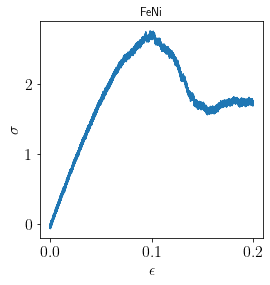

In [17]:
if not ReadStrsFromDump:

    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\epsilon$',fontsize=16)
    ax.set_ylabel(r'$\sigma$',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_title(fileNamee[:-4])
    #
    strain = stress[:,0]
    Virial = stress[:,1]
    ax.plot(strain,Virial,'-')
    #
    plt.savefig(fileNamee[:-4]+'.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    np.savetxt('loadCurve.txt',np.c_[np.array(strain), Virial])

## multiple systems

In [18]:
if not RemoteMachine:
    unrescaled = True
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                            'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/Run2/loadCurve.txt'%GlassType)
#        gmodu = np.loadtxt('StrsStrn%s/Run2/ShearModulus.txt'%GlassType)[1]
    #    sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
    #    assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        nfreq = np.max([1,int(len(sarr)/100)])
        ydata = sarr[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = sarr[0::nfreq,0] #--- 2nd and 3rd cols are widths
#         if unrescaled:
#             gmodu = 1
    #
#        ax.plot(xdata,ydata/gmodu,'-',color=color)#, label = GlassType)
        ax.plot(xdata,ydata,
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/10),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## multiple Realizations

In [19]:
if not RemoteMachine:
    unrescaled = True
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\gamma$',fontsize=20)
    ax.set_ylabel(r'$\sigma$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         '0','1','2'
                                        ],markers, colors, fillstyles )):

        try:
            gglass=['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26'][3]
            sarr  = np.loadtxt('d2min%s/Run%s/loadCurve.txt'%(gglass, GlassType) )
            #--- fliter
            nfreq = np.max([1,int(len(sarr)/1000)])
            ydata = sarr[0::nfreq,1] #--- first 2nd col is stress drop
            xdata = sarr[0::nfreq,0] #--- 2nd and 3rd cols are widths
        #
            ax.plot(xdata,ydata,
                    markersize=10,
                    color=color,
                    marker=marker,
                    markerfacecolor=fillstyle,
                    markeredgecolor='black' if not fillstyle else None,
                    markevery=int(len(xdata)/10),
                    label = '%s'%GlassType)
        except:
            continue
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## find stress peak and corresponding strain
### Fit a spline

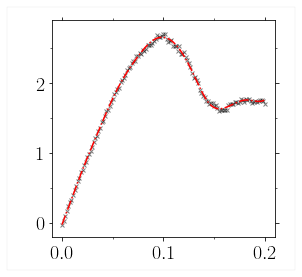

In [20]:

def ReturnShapeFunc(x,df):
#    eps1=0.0;eps2=0.0
#    n = len(x)
#    x2 = x * x
#    x3 = x * x2
#    x4 = (x-eps1)**3
#    x5 = (x-eps2)**3
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg

def Validate(reg, x,y,deg_f=range(0,40,10),cv_samples=10):
    mse={}
    for df in deg_f:
#    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse

def YieldStress(x,y_pred):
    #--- max. stress
    y_pred_arr = np.array(y_pred.flatten())
    indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
    ey =  x[indx]
#    print('ey=',ey)

    #--- yield stress
    sy =  y_pred_arr[indx]
#    print('sy=',sy)
    assert sy > 0.0

    #--- max. slope
    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[ydiff==np.min(ydiff[x>ey])][0]
    em = x[indx]
    sm =  y_pred_arr[indx]
    dsm = ydiff[x>=em][0]
#    print('em=',em)

    #--- flow stress
#    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>em])][0]
    ef = x[indx]
    sf =  y_pred_arr[indx]
    
    #--- modulus
    xdata = x[x<0.5*ey]
    ydata = y_pred[x<0.5*ey]
    xdata -= np.mean(xdata)
    ydata -= np.mean(ydata)
    gmodu = np.polyfit(xdata, ydata, 1)[0] #ydiff[0]

    return (ey,sy), (em,sm,dsm), (ef,sf), gmodu

def YieldStress2nd(x,y_pred):
    #--- max. stress
    y_pred_arr = np.array(y_pred.flatten())
    indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
    ey =  x[indx]
#    print('ey=',ey)

    #--- yield stress
    sy =  y_pred_arr[indx]
#    print('sy=',sy)
    assert sy > 0.0



    #--- flow stress
    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>ey])][0]
    ef = x[indx]
    sf =  y_pred_arr[indx]


    #--- max. slope
#    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[ydiff==np.min(ydiff[x<ef])][0]
    em = x[indx]
    sm =  y_pred_arr[indx]
    dsm = ydiff[x>=em][0]
#    print('em=',em)

    #--- modulus
    xdata = x[x<0.5*ey]
    ydata = y_pred[x<0.5*ey]
    xdata -= np.mean(xdata)
    ydata -= np.mean(ydata)
    gmodu = np.polyfit(xdata, ydata, 1)[0] #ydiff[0]
    
    
    return (ey,sy), (em,sm,dsm), (ef,sf), gmodu


if ReadStrsFromDump:
    strain = strainDump

x, y = np.array(strain), np.array(Virial)
#--- training points
transfrm = ReturnShapeFunc(x,13)
    
#--- train
reg = TrainModel(transfrm,np.c_[y])

#--- prediction
y_pred = reg.predict( transfrm )
    

#--- validate
#mse = Validate(reg, strain,np.c_[y])

#--- yield stress
try:
    (ey,sy), (em,sm,dsm), (ef,sf), gmodu = YieldStress(x,y_pred)
except:
    (ey,sy), (em,sm,dsm), (ef,sf), gmodu = YieldStress2nd(x,y_pred)

#--- write on the disk
np.savetxt('NegativeModulus.txt',np.c_[em,-dsm],header='Strain\tModulus')
np.savetxt('ShearModulus.txt',np.c_[0,gmodu],header='Strain\tModulus')

#--- plot
fig = plt.figure( figsize=(4,4))
ax = fig.add_subplot(111)
#ax.set_ylabel(r'$\sigma$(Gpa)',fontsize=16)
#ax.set_xlabel(r'$\gamma$',fontsize=16)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#
ax.plot( x, y,  'x',
        alpha=0.5,
        markersize=4,
        color='C0',
         markerfacecolor='white',
         markeredgecolor='black',
         markevery=int(len(x)/128)
       )
ax.plot(x, y_pred,'-.r')
if AssignYieldTime:
    ax.plot([ey,ey], [ax.axis()[2],sy],'-.r')
elif AssignMaxDropTime:
#    ax.plot([em,em], [ax.axis()[2],sm],'-.r')
    ax.plot(em, sm,'s',color='black',markersize=8,         
#             markerfacecolor='white',
#          markeredgecolor='black',
           )
elif AssignFlowTime:
    ax.plot([ef,ef], [ax.axis()[2],sf],'-.r')
#
DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
#
plt.savefig('hminIllustration.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
plt.show()


In [21]:
times = lmpData.coord_atoms_broken.keys()
times = np.array(sorted(times))
if AssignYieldTime:
    itime = times[strainDump>=ey][0]
    print('itime(peak)=%s'%itime)    
elif AssignMaxDropTime:
    itime = times[strainDump>=em][0]
    print('itime(max. drop)=%s'%itime)
elif AssignFlowTime:
    itime = times[strainDump>=ef][0]
    print('itime(flow)=%s'%itime)

### test error vs. complexity

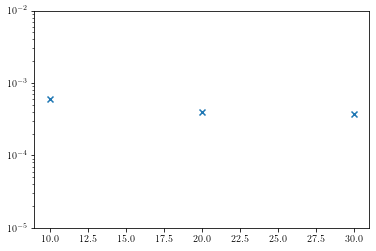

In [22]:
if AssignYieldTime or AssignMaxDropTime or AssignFlowTime:
    mse = Validate(reg, strain,np.c_[y])
    try:
        keys=mse.keys()
        plt.scatter(keys, [-mse[key] for key in keys],marker='x')
        plt.yscale('log')
    #    plt.xscale('log')
        plt.ylim(1e-5,1e-2)
        plt.savefig('cv.png',dpi=75,bbox_inches='tight')
        plt.show()
    except:
        pass

## mismatch parameter 

In [23]:
def GetMismatch(lmpData,itime,AtomicRadius):
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    df = pd.DataFrame(atoms.__dict__)
    #size = list(map(LatticeConstant.get,list(map(int,df['type'].tolist()))))
    size = list(map(AtomicRadius.get,list(map(int,df['type'].tolist()))))
    assert len(size) == len(df)
    df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])

    return df['size'].std()/df['size'].mean()

delta = GetMismatch(lmpData,0,AtomicRadius)
delta_g = GetMismatch(lmpData,0,Gmodu)
       
       
np.savetxt('YieldDelta.txt',np.c_[delta,sy],header='AtomMismatch\tYieldStress')
np.savetxt('ModuMismatch.txt',[delta_g],header='ModuMismatch')



### multiple frames

In [24]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    Xdata = []
    Ydata = []
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel('$\delta$',fontsize=20)
#     ax.set_ylabel('$\sigma_y$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = MultipleFrames2nd(path='YieldStrs%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        #--- fliter
        xdata = sarr[:,0]
        ydata = sarr[:,1]
        Xdata += list(xdata[~np.isnan(xdata)])
        Ydata += list(ydata[~np.isnan(ydata)])
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%GlassType)

    #
#    ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('YieldDelta.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    np.savetxt('YieldDelta.txt',np.c_[Xdata,Ydata],header='Mismatch\tYieldStrs')
    plt.show()

## Avalanche Size

564991 [-1.02496576]
117648 [-0.02073347]


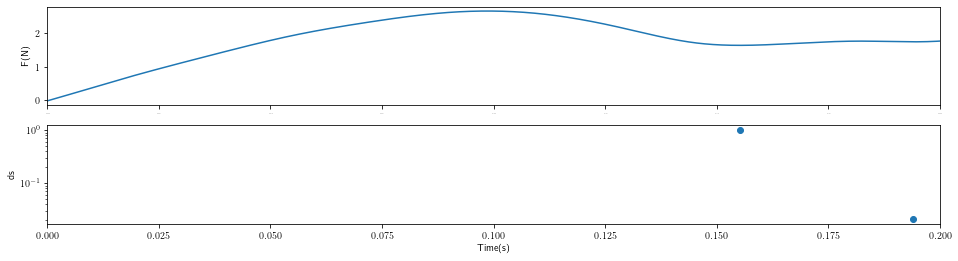

In [25]:
if ReadStrsFromDump:
    strain = strainDump
df = AvalancheSize(strain, y_pred) #
esmax,dsmax=df.sort_values(by='ds',ascending=False).iloc[0][['t_end','ds']]
np.savetxt('StrsDrop.txt',np.c_[esmax,dsmax],header='StressDrop')

# #--- plot
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(211)
ax.set_xlim(strain.min(),strain.max())
ax.tick_params(axis='x',labelsize=0)
ax.set_ylabel('F(N)')
#
ax.plot(strain, y_pred,'-')
#
ax = fig.add_subplot(212)
ax.set_ylabel('ds')
ax.set_xlabel('Time(s)')
ax.set_yscale('log')
ax.set_xlim(strain.min(),strain.max())
#
ax.scatter(df['t_end'],df['ds'])
#
plt.show()

### Correlations with band width

In [26]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    # ax.set_xlabel('$w(A^o)$',fontsize=20)
    # ax.set_ylabel('$\Delta\sigma$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                         'CoNiFe',
                                         'CoNiCrFe',
                                         'CoCrFeMn',
                                         'CoNiCrFeMn',
                                         'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles)):

        sarr_StrsDrop  = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='StrsDrop.txt',ncols=2)
        sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        ydata = sarr_StrsDrop[:,1] #--- first 2nd col is stress drop
        xdata = sarr_BandWidth[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        xdata = xdata[~np.isnan(xdata)]
        ydata = ydata[indices]
        assert xdata.shape == ydata.shape
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%GlassType)

    #
    #ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('StrsDropAndWidth.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### (negative) modulus and band width

In [27]:
if not RemoteMachine:
    prefact=1.3
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
#
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    # ax.set_xlabel('$w(A^o)$',fontsize=20)
    # ax.set_ylabel('$H$(Gpa)',fontsize=20)
    PutMinorTicks(ax)
    ax.tick_params(labelsize=20*prefact,which='both',axis='both', top=True, right=True)
    #
    Xdata = []
    Ydata = []
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                         'CoNiFe',
                                          'CoNiCrFe',
                                          'CoCrFeMn',
                                           'CoNiCrFeMn',
                                          'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles)):

        sarr_StrsDrop  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
        sarr_BandWidth = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        sarr_Mismatch = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
#        assert sarr_StrsDrop.shape[0] == sarr_Mismatch.shape[0]
        #--- fliter
        ydata = sarr_StrsDrop[:,1] #--- first 2nd col is stress drop
#        xdata = sarr_BandWidth[:,1:3] #--- 2nd and 3rd cols are widths
        xdata = sarr_Mismatch[:,0] #--- 2nd and 3rd cols are widths
    #    print(xdata,ydata)
#         indices = np.any(~np.isnan(xdata),axis=1)
#         xdata = xdata[~np.isnan(xdata)]
#         ydata = ydata[indices]
#         assert xdata.shape == ydata.shape
    #    print(xdata,ydata)
        Xdata += xdata.tolist()
        Ydata += ydata.tolist()
        #
        ax.plot(xdata,-ydata,'.',
                markersize=10*prefact,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%GlassType)
        #
#    ax.legend(frameon=False, fontsize=16,bbox_to_anchor=(1,1))

#    PutMinorTicks(ax)
            
    tickLabels=np.array([30,25,20,15])
    ax.yaxis.set_ticklabels(['-$%s$'%i for i in tickLabels])
    ax.yaxis.set_ticks(-tickLabels)

        
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('SoftModuAndDelta.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

In [28]:
#RemoteMachine=None

### correlation coefficient

In [29]:
def zscore(x):
    y = np.copy(x)
    y-=np.mean(y)
    y/=np.std(y)
    return y

if not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_xlabel('$w(A^o)$',fontsize=16)
    ax.set_ylabel('$H$(Gpa)',fontsize=16)
    ax.tick_params(labelsize=16)
    x = zscore(Xdata)
    y = zscore(Ydata)
    ax.scatter(x,y,
                   marker='x',s=50,
    #               label=GlassType
              )

    print(np.sum(x*y)/len(x))

# Compute Displacements


In [31]:
if CompDisp:
    #--- extract atom and box properties
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

    #--- wrap coordinates
    wrap = lp.Wrap( atoms, box )
    wrap.WrapCoord()
    wrap.Set( atoms ) #--- atoms: set wrapped xyz     

    #--- print actual xyz
    # PrintOvito( pd.DataFrame(atoms.__dict__), 
    #              open( 'xyz_actual.xyz','w'), 
    #              footer = 'ITIME=%s'%itime,
    #              attr_list=['id','type','x','y','z'])

    #--- map to square box
    mapp = lp.Map( atoms, box ) 
    mapp.ChangeBasis()
    mapp.Set( atoms ) #--- atoms: add mapped xyz

    #--- print mapped xyz
    # PrintOvito( pd.DataFrame(atoms.__dict__), 
    #             open( 'xyz_mapped.xyz','w'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','xm','ym','zm'] )

    #--- include copies
    copy = lp.Copy( atoms, box )
    copy.FullCopies()
    xatoms = copy.Get()

    #--- print mapped xyz
    # PrintOvito( pd.DataFrame(xatoms.__dict__), 
    #             open( 'xyz_full.xyz','w'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','xm','ym','zm'] )

    #--- compute displacements
    #--- need attributes for the reference state
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    wrap = lp.Wrap( atoms0, box0 )
    wrap.WrapCoord()
    wrap.Set( atoms0 ) #--- atoms: set wrapped xyz    
    mapp = lp.Map( atoms0, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( atoms0 ) #--- atoms: add mapped xyz
    copy = lp.Copy( atoms0, box0 )
    copy.FullCopies()
    xatoms0 = copy.Get()
    #
    cdisp = lp.ComputeDisp( xatoms, box, xatoms0, box0 ) #--- pass full copies!
    cdisp.SetWrapped() 
    uatoms = cdisp.Get(attrs = ['id','type','x','y','z','xm','ym','zm','dx','dy','dz'] ) #--- all atom-wise props
    #
    pd.DataFrame(uatoms.__dict__).head()

In [32]:
# #--- shuffled displacements
if CompDisp and ShuffleDisp:
    xrand = np.c_[uatoms.dx,uatoms.dy,uatoms.dz]
    np.random.shuffle(xrand)
    junk = np.c_[uatoms.id, uatoms.type, uatoms.x, uatoms.xm, uatoms.y, uatoms.ym, uatoms.z,
           uatoms.zm]
    cols = [u'id', u'type', u'x', u'xm', u'y', u'ym', u'z',u'zm']
    #np.c_[junk,xrand]
    uatoms = lp.Atoms(**pd.DataFrame(np.c_[junk,xrand],columns=cols+['dx','dy','dz']).to_dict(orient='list'))

## Print

In [33]:
#--- get a chunk
# cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
# indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
#                                   epsilon = 0.0, mode = 'isotropic' )


# PrintOvito( pd.DataFrame(uatoms.__dict__)[indices], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','x','y','z','dx','dy','dz'] )

# Neighbor list

In [815]:
if NeighList:
    try:
        !rm neighList.xyz
    except:
        pass

    rpeak = dlgr0
    cutoff=8.0 #1.1*rpeak #--- 1st peak=2.5
    sigma=0.05*rpeak
    !ovitos OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff

InputFile= /Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=200


In [816]:
if NeighList:
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)

In [817]:
lmpNeigh.coord_atoms_broken[0].head()

,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,4,49940.0,4.0,5.957271,-2.570300,-3.489500,4.087299,0.0,0.0,0.0
1,1,4,30045.0,2.0,6.236000,4.930901,-1.699000,-3.418671,0.0,0.0,-1.0
2,1,4,33788.0,1.0,6.101467,3.220200,-5.016100,-1.302670,0.0,0.0,-1.0
3,1,4,23130.0,2.0,7.671641,2.370001,-6.210601,-3.829571,0.0,0.0,-1.0
4,1,4,27817.0,4.0,6.866058,3.938000,-4.288600,-3.639069,0.0,0.0,-1.0


# Compute pair correlation function

In [34]:
if PairCorrelationFunction and not Ovitos:
    d2min = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    thresh=np.log10(thresh[itime])
    cutoff=20.0/2
    NMAX=10000*4
    filtr = np.log10(d2min.d2min)>thresh


    rdf = lp.ComputeRdf(  atoms, box, 
                       cutoff = cutoff, NMAX = NMAX)

    rdf.Distance(WRAP = True, FilterCenter = filtr)
    rdf.PairCrltn( nbins = 100, bins=np.linspace(2.0,cutoff,100) )
    bin_edges, hist, err = rdf.Get()

    #--- plot
    plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')
    
    #---
    np.savetxt('grGood95.txt',np.c_[bin_edges,hist,err],header='r\tg(r)\terr', fmt='%s')
    plt.show()

## ovito output

In [35]:
try:
    sfile = open('../testRuns/glassFeNi/Run0/FeNi_gr.xyz') #--- run testRuns2nd.py
    gr={}
    while True:
        sfile.readline()
        iitime=int(sfile.readline().split()[0])
#        print(iitime)
        sfile.readline()
        nrow=int(sfile.readline().split()[0])
        sfile.readline()
        gr[iitime] = np.array([list(map(float,sfile.readline().split())) for i in range(nrow)])
except:
#    traceback.print_exc()
    pass


### Plot

In [36]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlim(2,3)
    
#    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for strain, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        '0.0','0.2'
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        iitime = int(float(strain)*2000000/0.2)
        print(iitime)
        #--- fliter
        data  = gr[iitime]
        ydata = data[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = data[0::nfreq,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,'-',color=color)#, label = GlassType)
        ax.plot(xdata[-1],ydata[-1],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%strain)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('CrysFrac.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### plot gr good vs bad

In [37]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e-2,1e1)
    ax.set_xlim(0,10)

    ax.set_yscale('log')
    #
    PutMinorTicks(ax, LOGY=True)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    ydata = {}
    xdata = {}
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Out','In','Diff'
#                                        '5','95','QuantDiff'
                                         ('Good','Co5Cr2Fe40Mn27Ni26'),('Bad','CoNiCrFe'),('Diff','Difference')
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        sarr  = np.loadtxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/gr%s95.txt'%GlassType[0])
        #--- fliter
        ydata[ indx ] = sarr[:,1] #--- first 2nd col is stress drop
        xdata[ indx ] = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata[ indx ],ydata[ indx ],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata[ indx ])/5),
                label = '%s'%GlassType[1])
    #
    ax.legend(frameon=False, fontsize=12,loc=1)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('grD2min.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

In [220]:
#np.savetxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/grDiff95.txt',np.c_[xdata[0],ydata[1]-ydata[0]])

# D2min

## partition the space, make fits, and compute squared errors 

In [655]:
if DminAnalysis and not Ovitos:
    #--- Create "Atoms" object with dx,x attributes and
    #--- atoms within the original box
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.0, mode = 'isotropic' )
    #--- filter the full copy
    atomd = lp.Atoms(**pd.DataFrame(uatoms.__dict__)[indices].to_dict(orient='list'))
    #
    d2min = lp.ComputeD2min(atomd, box0, dlgr)
    d2min.Partition()
    d2min.D2min()
#    pdb.set_trace()
    d2min = d2min.Get(attrs=['id','type','x','y','z','xm','ym','zm','d2min'])
    #
    pd.DataFrame(d2min.__dict__).head()


## Run Ovitos

In [656]:
#--- input: dump file output: d2min.xyz
if DminAnalysis and Ovitos:
    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease it!'
    try:
        os.system('rm d2min.xyz')
    except:
        pass
    !ovitos OvitosCna.py $fileName d2min.xyz $nevery 2 $fileName


InputFile= /Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=200


In [211]:
#fileName='/Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump'
#fileName='/Users/Home/Desktop/Tmp/txt/CoNiCrFe_glass.dump'
#nevery=20

In [657]:
#--- read from d2min.xyz
if DminAnalysis and Ovitos:
    lmpDmin = lp.ReadDumpFile( 'd2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

In [658]:
lmpDmin.coord_atoms_broken.keys()

dict_keys([0, 2000000])

In [659]:
lmpDmin.coord_atoms_broken[0]

,id,type,x,y,z,d2min
0,1,4,14.944500,-10.674100,-42.781799,7.329279e-12
1,2,2,-11.308300,-19.820101,-9.716890,3.293208e-14
2,3,1,-36.601200,-16.576500,11.127100,9.064500e-14
3,4,2,-27.747999,-20.608601,-19.674700,7.600706e-14
4,5,2,-13.464700,19.576700,16.919300,9.880446e-14
...,...,...,...,...,...,...
50683,50684,4,-5.663320,34.009102,8.788330,8.002400e-14
50684,50685,4,-24.970600,7.675140,-28.352501,4.635859e-14
50685,50686,1,-39.609798,-33.054298,3.989510,2.157343e-11
50686,50687,2,-31.157600,-11.373600,-16.157400,2.936547e-14


## PDF

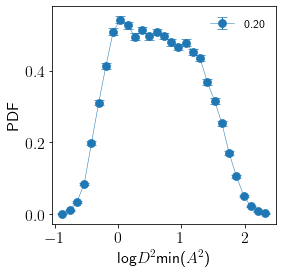

itime=2000000, ratio=0.5740806502525253


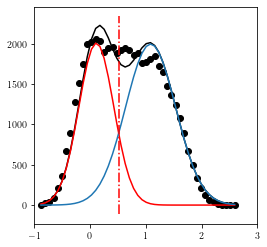

In [196]:
def PdfD2min( lmpData, times,     
             Plott = True
             ):
    #--- plot
    if Plott:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #    ax.set_yscale('log')
        #ax.set_xscale('log')
        # ax.set_ylim(1e-5,10)
        # ax.set_xlim(1e-2,1e4)
        ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
        ax.set_ylabel(r'PDF',fontsize=16)
        ax.tick_params(labelsize=16)
        #ax.set_title(r'itime=%s'%itime)

    Mean = []
    Std = []
    Ebulk = []
    D2min = {}
    for itimee in sorted(times): #[0::nn]:

        # strain
        ebulk = GetStrain(lmpData, [itimee], 0 )[itimee]
#         if ebulk == 0.0:
#             continue
        Ebulk += [ebulk]    

        #--- d2min
        d2min = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
        D2min[ itimee ] = np.array(d2min.d2min)
        Std += [ np.std(d2min.d2min) ]
        Mean += [ np.mean(d2min.d2min) ]

    #--- size distribution
        if Plott:
            value = d2min.d2min
            hist, edges2, error = GetPDF( np.log10(value), linscale = True, n_per_decade=32)

        #
            ax.errorbar(edges2,hist,error,fmt='-o',
                        markersize=8,markeredgewidth=0.7,
                            linewidth=.5,
                             barsabove=None,capsize=5,capthick=1,elinewidth=1,label='%3.2f'%ebulk)
    #
    if Plott:
        ax.legend(frameon=False, fontsize=12)
        plt.savefig('pdfD2min.png',dpi=75,bbox_inches='tight')
        plt.show()
        
    return Ebulk, Mean, Std, D2min



if DminAnalysis and Ovitos:
    junk, junk, junk, d2min = \
    PdfD2min( lmpDmin, 
              #times = [0,2000000],
              times=[itime],#list(lmpDmin.coord_atoms_broken.keys()),     
              Plott = True
             )
    
    thresh, ratio, junk = gaussian_mixture(
                                     d2min,
                                     times = list(d2min.keys()), 
                                     PLOT = True,
                                 )
    
        #--- save
    strn = GetStrain(lmpDmin, 
                     times = [itime], #list(lmpDmin.coord_atoms_broken.keys()), 
                     time0 = 0 )
    np.savetxt('varD2minGamma.txt',
               np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
               header='gamma\tratio')


### variance 

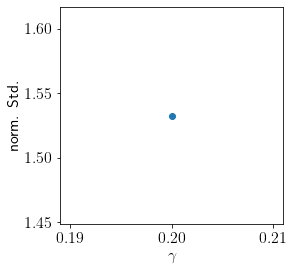

In [69]:
# if DminAnalysis and Ovitos:
#     Ebulk, Mean, Std=\
#         PdfD2min( lmpData, 
#         times = lmpData.coord_atoms_broken.keys(),     
#         Plott = None
#         )
#     #--- plot
#     fig = plt.figure(figsize=(4,4))
#     ax = fig.add_subplot(111)
#     # ax.set_yscale('log')
#     # ax.set_xscale('log')
#     # ax.set_ylim(1e-5,10)
#     # ax.set_xlim(1e-2,1e4)
#     ax.set_xlabel(r'$\gamma$',fontsize=16)
#     ax.set_ylabel(r'norm. Std.',fontsize=16)
#     ax.tick_params(labelsize=16)
#     #ax.set_title(r'itime=%s'%itime)
#     #
#     ax.plot(Ebulk,np.array(Std)/np.array(Mean),'-o')
#     #
#     np.savetxt('D2minGamma.txt',np.c_[Ebulk,np.array(Std)/np.array(Mean)],header='Strain\tD2minStd')
#     #
#     plt.savefig('D2minGamma.png',dpi=75,bbox_inches='tight')
#     plt.show()

### multiple realizations

In [45]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\gamma$',fontsize=20)
    ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         '0','2'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2minCoNiFe/Run%s/D2minGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=6*4,
                label = '%s'%GlassType)
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### multiple systems

In [46]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                          'FeNi', #0,1,2
#                                           'CoNiFe', #0,2
                                             'CoNiCrFe/Run2', #0,1,2  ## bad 7
#                                             'CoCrFeMn', #0,1,2
#                                             'CoNiCrFeMn', #1,2 ##
                                            'Co5Cr5Fe40Mn27Ni26/Run0'# 0,1,2 # good 13
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/D2minGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=6*4,
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Interpolation

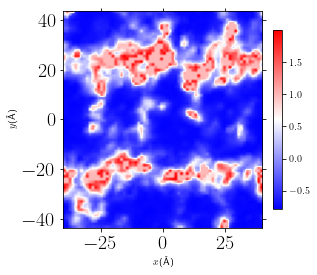

In [389]:
if DminAnalysis:
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    junk, junk, d2intrp = Intrp(atom, box0,
                    attr = 'd2min',
                    Plot = True,
                    title='map_d2min.png'
                   )

### Print Ovito output

In [47]:
def PlotOvito( d2intrp, times):
    #--- print 
    file_name = 'd2minIntrp.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass


    
    for itime in sorted(times):
        PrintOvito( pd.DataFrame(d2intrp[itime].__dict__), 
                    open(file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
    #                attr_list=['id','type','xm','ym','zm','d2min'],
                    attr_list=['x','y','z','d2min'] 
                  )

    # #--- current frame
    # d2minList=pd.DataFrame(d2min.__dict__).sort_values(by='id', ascending=True, inplace=False)['d2min']
    # df = pd.DataFrame(atoms.__dict__).sort_values(by='id', ascending=True, inplace=False)
    # #attrs = 
    # d2min2 = lp.Compute( atoms, box )
    # d2min2.Set(np.c_[df,d2minList],attrs=list(df.keys()) + ['d2min'])
    # attrs = ['id','type','x','y','z','d2min']
    # d2min2 = pd.DataFrame(np.c_[list(map(d2min2.__dict__.get,attrs))].T, columns = attrs )
    # PrintOvito( d2min2, 
    #             open(file_name,'a'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','x','y','z','d2min'] )

if DminAnalysis:# and not Ovitos:
    PlotOvito( d2intrp, 
              times=[itime], #[2000000], #list(d2intrp.keys()),
             )

#### Paper version

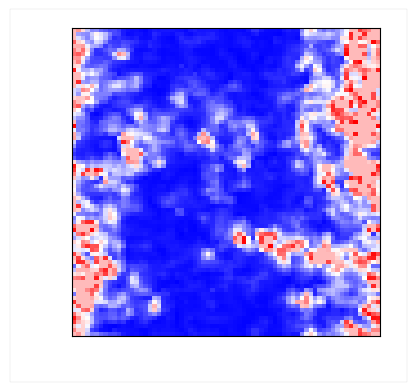

In [58]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    
    val = np.loadtxt('ShearBandFeNi/Run2/d2minBitmap.txt')
    PltBitmap(   val, 
                  xlabel = '', ylabel = '',
    #              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                  zscore = True,
                  frac = 1.0, #--- plot a patch
                  title = 'd2min.png',
                  colorbar=None,
                  DrawFrame=(0.2,0.09,0.15,0.06,0.04),
                )
#DrawFrame(ax, 0.2,0.09,0.15,0.06,4)


## Crltn Function (Unstructured points)

In [217]:
if DminAnalysis and CrltnFunctionUnstructured and not Ovitos:
    crltn = lp.ComputeCrltn(  d2min, box, 
                              d2min.d2min, #--- values
                              cutoff = cutoff, #--- cutoff size to include neighbors
                              dx = dlgr0, #--- discretization length: 1st peak in rdf
                              NMAX = NMAX, #--- upper bounds for the number of atoms
                            )
    crltn.Distance()
    crltn.AutoCrltn(RADIAL = None)
    xvv, yvv, zvv, hist, err = crltn.Get()

    #--- save data
    np.save('CrltnFuncUnstructured',np.c_[xvv, yvv, zvv, hist, err])

In [218]:
# n=1000*4
# xyz = np.random.random((n,3)) 
# atom_tmp = lp.Atoms(**pd.DataFrame(np.c_[np.arange(n),np.ones(n),xyz],
#                                    columns=['id','type','x','y','z']).to_dict(orient='list'))
# box_tmp = lp.Box(CellOrigin=np.array([0,0,0]),CellVector=np.array([[1,0,0],[0,1,0],[0,0,1]]))
# #val = np.sin(2*np.pi*xyz[:,0])
# rstar = 0.25
# xyz = xyz - np.array([0.5,0.5,0.5])
# val = np.exp(-0.5*(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)/rstar/rstar)
# crltn = lp.ComputeCrltn(    atom_tmp, box_tmp,
#                              val,
#                              cutoff=1.0*3**.5, dx=0.05,
#                              NMAX = n
#                      )
# crltn.Distance()
# crltn.AutoCrltn(RADIAL = None)
# xvv, yvv, zvv, hist, err = crltn.Get()

# dlgr0 = 0.05/2

### Plot Crltns

In [203]:
#--- load data
# sdata = np.load('CrltnFuncUnstructured.npy')
# nz = sdata.shape[2]/5
# xv = sdata[:,:,0:nz]
# yv = sdata[:,:,nz:2*nz]
# zv = sdata[:,:,2*nz:3*nz]
# hist = sdata[:,:,3*nz:4*nz]
# err = sdata[:,:,4*nz:5*nz]

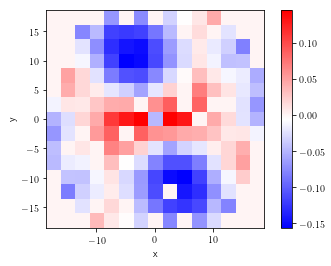

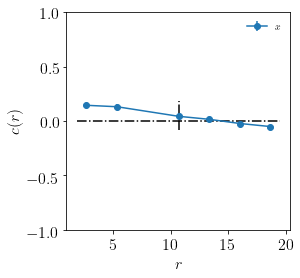

10.699313962120927

In [219]:
if DminAnalysis and CrltnFunctionUnstructured and not Ovitos:
    #--- get 2d slice
    xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                           xvv, yvv, zvv,
                                           z=0.0, xtol = dlgr0/2
                                          )
    #--- bitmap
    PltBitmap(hist2d, 
              xlabel = 'x', ylabel = 'y',
              xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
              zscore = None,
              frac = 1.0, #--- plot a patch
              ) 

    #--- get 1d slice
    xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                                 xv2d, yv2d,
                                 xtol = dlgr0/2,
                                 y=0.0)   
    #--- plot
    PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                     xv1d[xv1d>0.0],
                     fileName = 'cr.%s.png'%itime,
    #                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                     cTOL = 8.0e-2,
                     dpi = 60,
                    )

## Crltn Function (FFT)

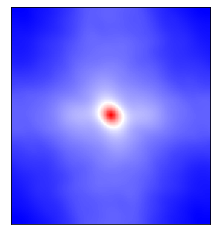

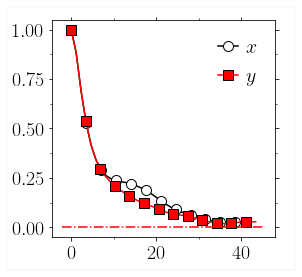

In [282]:
def CrltnFunctionFFT( lmpData, times, Plot = True):
    
    for itime in times:
        (xlin,ylin,zlin), (xv, yv, zv), d2intrp = Intrp( lmpData, 
                                            times=[itime], time0=0, 
                                            Plot = None )

        (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
        #
        value = np.c_[d2intrp[itime].d2min].reshape((ny,nx,nz))

        #--- shuffle
        #     ( nx, ny, nz ) =  value.shape
        #     slist = value.flatten()
        #     np.random.shuffle(slist)
        #     value=slist.reshape((nx, ny, nz))    
        #
        #--- filter value
        #     value = FilterMatrix( CellVector[0], CellOrigin[0],
        #                   (xlin, ylin, zlin),
        #                   (xv, yv, zv ),
        #                    value )

        crltn = GetAutoCorrelation( value )

        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    

        #--- xy plane
        val = crltn[:,:,0].copy()
        PltCrltn( val, 
                  xlabel = 'x', ylabel = 'y',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  frac = 1, #--- plot a patch
                  zscore = False,
                  fileName = 'cxy_d2minBad.%s.png'%itime,
                  dpi = 60
                )

        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk = dx/l1
        #---
        (xc, yc), (xdata0,ydata0), (xdata,ydata) =\
                PltCrltnFunc(   crltn, 
                                 xv,yv,
                                 fileName = 'cr_d2minBad.%s.png'%itime,
                                 title = '', #r'$\gamma=%3.2f$'%(ebulk),
                                 cTOL = 1.0e-2,
                                 dpi = 150,
                                )
        #--- save
        np.savetxt('rc_d2min.txt',np.c_[ebulk, xc, yc],header='gamma\txc\tyc')
    
    
if DminAnalysis:
    CrltnFunctionFFT(lmpDmin, 
                    times = [itime], #[2000000], #list(lmpData.coord_atoms_broken.keys()),
                    Plot = True,
                    )

### Multiple Frames

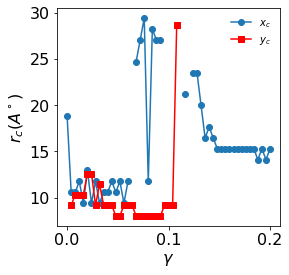

In [74]:
if not RemoteMachine:
    sarr = MultipleFrames('widthFeNi','rc_d2min.txt',irun=0)
#--- plot
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    xstr = r'$\gamma$'
    ystr = r'$r_c(A^\circ)$'
    ax.set_xlabel(xstr,fontsize=16)
    ax.set_ylabel(ystr,fontsize=16)
    ax.tick_params(labelsize=16)
    #
    ax.plot( sarr[:,0], sarr[:,1],'-o', color='C0', label = r'$x_c$')
    ax.plot( sarr[:,0], sarr[:,2],'-s', color='red', label = r'$y_c$')
    ax.legend(frameon=False)
    plt.savefig('rc.png',dpi=75,bbox_inches='tight')
    plt.show()


### Band width vs. mismatch

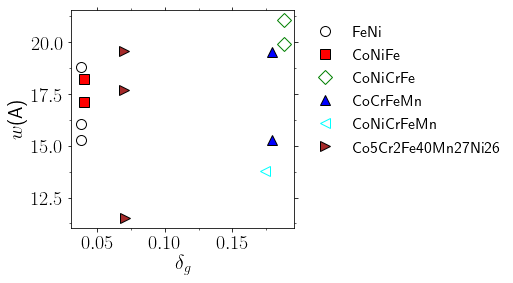

In [23]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_ylabel('$w$(A)',fontsize=20)
    ax.set_xlabel('$\delta_g$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
                                         'FeNi',
                                         'CoNiFe',
                                         'CoNiCrFe',
                                         'CoCrFeMn',
                                         'CoNiCrFeMn',
                                         'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles, range(10))):
        try:
            sarr_BandWidth = MultipleFrames2nd(path='widthMismatch%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
            sarr_Mismatch = MultipleFrames2nd(path='widthMismatch%s'%GlassType,nrun=3,title='ModuMismatch.txt',ncols=1)
            #--- fliter
#            xdata = ModuMismatch[indxx+1]*np.ones(3) #sarr_Mismatch[:,0]
            xdata = sarr_Mismatch[:,0]
            ydata = sarr_BandWidth[:,1:3] #--- 2nd and 3rd cols are widths
            indices = np.any(~np.isnan(ydata),axis=1)
            ydata = ydata[~np.isnan(ydata)]
            xdata = xdata[indices]
            assert xdata.shape == ydata.shape
            #
            ax.plot(xdata,ydata,'.',
                    markersize=10,
                    color=color,
                    marker=marker,
                    markerfacecolor=fillstyle,
                    markeredgecolor='black' if not fillstyle else None,
                    label = '%s'%GlassType)
        except:
            traceback.print_exc()
            continue

    #
    ax.legend(frameon=False, fontsize=16,bbox_to_anchor=(1,1))
    #
#    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('widthMismatch.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# Voronoi Analysis

In [552]:
if VorAnl and Ovitos:
    try:
        !rm Voronoi.xyz
    except:
        pass
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    rad4=0.0#AtomicRadius[4]
    rad5=0.0#AtomicRadius[5]
    !ovitos OvitosCna.py $fileName Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3 $rad4 $rad5  

InputFile= /Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=200


In [553]:
#--- read from d2min.xyz
if VorAnl and Ovitos:
    lmpVor = lp.ReadDumpFile( 'Voronoi.xyz' )
    lmpVor.GetCords( ncount = sys.maxsize)

## histogram

(0, 0, 12, 0)	4738	(9.3 %)
(0, 1, 10, 2)	3667	(7.2 %)
(0, 2, 8, 2)	2358	(4.7 %)
(0, 2, 8, 4)	2167	(4.3 %)
(0, 3, 6, 4)	2071	(4.1 %)
(0, 1, 10, 3)	1555	(3.1 %)
(0, 1, 10, 4)	1537	(3.0 %)
(0, 0, 12, 2)	1267	(2.5 %)
(0, 2, 8, 5)	1108	(2.2 %)
(0, 0, 12, 3)	900	(1.8 %)


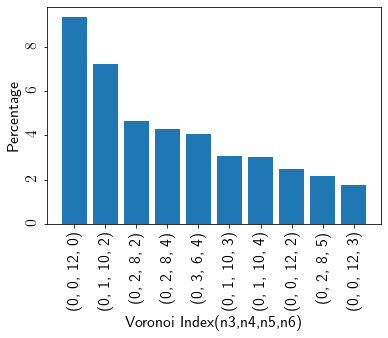

In [116]:
def row_histogram(a):
    ca = np.ascontiguousarray(a).view([('', a.dtype)] * a.shape[1])
    unique, indices, inverse = np.unique(ca, return_index=True, return_inverse=True)
    counts = np.bincount(inverse)
    sort_indices = np.argsort(counts)[::-1]
    return (a[indices[sort_indices]], counts[sort_indices])


        
def GetMotifs( lmpData, times, Plot = True ):
    Unique_indices={}
    Counts = {}
    for itime in times:
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
        #
        voro_indices = np.c_[vor.VoronoiIndex3,vor.VoronoiIndex4,vor.VoronoiIndex5,vor.VoronoiIndex6].astype(int)
        # Compute frequency histogram.

        unique_indices, counts = row_histogram(voro_indices)
        Unique_indices[itime]=unique_indices[:]
        Counts[itime]=100.0*counts/len(voro_indices)
        #
        # Print the ten most frequent histogram entries.
        if Plot:
            for i in range(10):
                print("%s\t%i\t(%.1f %%)" % (tuple(unique_indices[i]), 
                                         counts[i], 
                                         100.0*float(counts[i])/len(voro_indices)))
                plt.bar(str(tuple(unique_indices[i])), 100.0*float(counts[i])/len(voro_indices),color='C0')
            #
#             plt.yscale('log')
#             plt.ylim(.1,100)
            plt.xlabel('Voronoi Index(n3,n4,n5,n6)',fontsize=16)
            plt.ylabel('Percentage',fontsize=16)
            plt.tick_params(labelrotation=90,labelsize=16)
            #
            plt.savefig('motifs.png',dpi=75,bbox_inches='tight')
            plt.show()
            
    return Unique_indices, Counts
        
    
    
    
if VorAnl and Ovitos:
     GetMotifs( lmpVor, 
                times = [itime], #[2000000], #lmpData.coord_atoms_broken.keys(),
                Plot = True
              )

## Timeseries

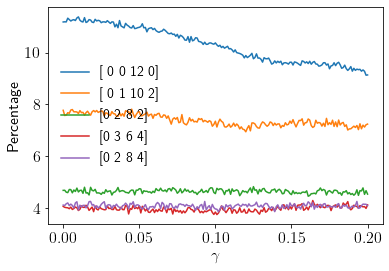

In [34]:
def GetMotifsTimeseries( lmpData, 
                         Motif = np.array([[0,0,12,0]]),
                       ):
    Unique_indices, Counts = GetMotifs( lmpData, 
                                         times = lmpData.coord_atoms_broken.keys(),
                                         Plot = False,
                                       )
    #
    strn =  GetStrain(lmpData, 
                      times=lmpData.coord_atoms_broken.keys(), 
                      time0=0 )
    #
    times = list(strn.keys())
    times.sort()
    #
    percent = {}
    for motif,indx in zip(Motif,range(len(Motif))):
        percent[indx] = {}
        for itime in times:
            counts = Counts[itime]
            unique_indices = Unique_indices[itime]
            percent[indx][itime] = counts[np.all(unique_indices== motif,axis=1)]
    #--- plot
#     plt.yscale('log')
#     plt.ylim(.1,100)
    plt.xlabel('$\gamma$',fontsize=16)
    plt.ylabel('Percentage',fontsize=16)
    plt.tick_params(labelsize=16)
    #
    for indx in range(len(Motif)):
        plt.plot(list(map(strn.get,times)),list(map(percent[indx].get,times)),
                 '-',
                 label = Motif[indx]
                )
    #
    plt.legend(frameon=False,fontsize=14)
    plt.savefig('motifsTimeSeries.png',dpi=75,bbox_inches='tight')
    plt.show()
    
    
    

if VorAnl and Ovitos:
    GetMotifsTimeseries( lmpData, 
                         Motif = np.array([[0,0,12,0],[0,1,10,2],[0,2,8,2],[0,3,6,4],[0,2,8,4]]),
                       )

## conditional pdf of d2min

KeyError: 2000000

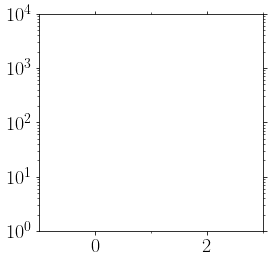

In [579]:

    
def PdfCondD2min( lmpData, lmpDmin, times,     
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.set_yscale('log')
        #ax.set_xscale('log')
        #
        ax.set_ylim(1,1e4)
        ax.set_xlim(-1,3)
        #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 

        # strain
        ebulk = GetStrain(lmpData, [itimee], 0 )[itimee]
#         if ebulk == 0.0:
#             continue

        #--- d2min and vor
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='list') )
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )

        #--- filter
        indices = GetFullIcosahedra( vor )

        #--- histogram: total
        value = valueTot[itimee]=np.array(d2min.d2min)
        hist, edges, error = GetPDF( np.log10(value), 
                                    linscale = True, 
                                    n_per_decade=32,
                                    density = False,
                                   )
        #--- filtered
        value = valueFiltrd[ itimee ] = np.array(d2min.d2min)[indices]
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = False,
                                                        )
        #--- invert
        valinv = np.array(d2min.d2min)[~indices]
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = False,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
    #             ax.errorbar(edges,hist,error,fmt='-o',
    #                         markersize=8,markeredgewidth=0.7,
    #                         linewidth=.5,
    #                          barsabove=None,capsize=5,capthick=1,elinewidth=1,label='Total')
                #
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='-o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label='Icosahedra', markevery = int(len(edges_filtrd)/10),
                        errorevery = int(len(edges_filtrd)/10),
                       )
            #
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='-s', color='red',
                        markerfacecolor=None, markeredgecolor='black',
                        label='Non Icosahedra',markevery = int(len(edges_inv)/10),
                        errorevery = int(len(edges_inv)/10),
                       )
    #
    if Plot:
        ax.legend(frameon=False, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()

    return valueFiltrd,valueTot

if DminAnalysis and VorAnl:
    
    PdfCondD2min( lmpVor, lmpDmin,
              times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
              Plot = True,
              title = 'pdfCondD2minBad.png',
              axisLabels = False,
             )

### gaussian mixture

itime=2000000, ratio=0.5715863897481219


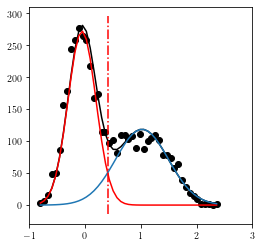

In [191]:
if DminAnalysis and VorAnl:
    
    d2minFiltrd, d2minTotal = PdfCondD2min( lmpVor, lmpDmin,
                                           #times = list(lmpData.coord_atoms_broken.keys()), 
                                           times=[itime], #[2000000],
                                           Plot = False,
                 )
    
    thresh, ratio, gsfitTotal = gaussian_mixture(
                                      #d2minTotal,
                                      d2minFiltrd,
                                     times = list(d2minFiltrd.keys()), 
                                      #times = [2000000],
                                      PLOT = True,
                                     )
    #--- save
#     nn=len(d2minFiltrd[2000000])
#     np.savetxt('d2minFiltrdGood.txt',d2minFiltrd[2000000])
#     np.savetxt('gsfitTotalGood.txt',gsfitTotal)

#     strn = GetStrain(lmpData, 
#                      times = list(lmpData.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#    np.savetxt('varD2minCondGamma.txt',
#               np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#               header='gamma\tratio')


#### evolution with strain

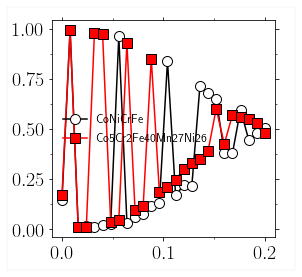

In [419]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                         'FeNi',
#                                         'CoNiFe',
                                        'CoNiCrFe/Run2',
#                                         'CoCrFeMn', 
#                                         'CoNiCrFeMn', 
                                        'Co5Cr2Fe40Mn27Ni26/Run0'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2minRatio%s/d2minRaioGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/20),
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### good, bad, and ugly!

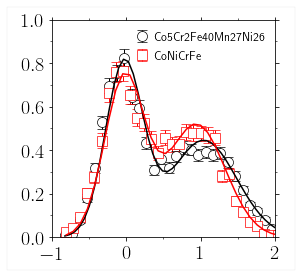

In [360]:
def PdfD2minGoodBad( lmpData, lmpDmin, badfit, goodfit,  times,  
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                    **kwargs
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
#        ax.set_yscale('log')
        #ax.set_xscale('log')
        #
#         ax.set_ylim(1,1e4)
#         ax.set_xlim(-1,3)
#         #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
#        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 



        #--- filtered
        value = lmpDmin
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = True,
                                                        )
        #--- invert
        valinv = lmpData
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = True,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
            nmark = 16
            label = kwargs['label1'] if 'label1' in kwargs else ''
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label=label, markevery = int(len(edges_filtrd)/nmark),
                        errorevery = int(len(edges_filtrd)/nmark), zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpDmin)
            dx=goodfit[:,0][1]-goodfit[:,0][0]
            ax.plot(goodfit[:,0],goodfit[:,1]/nn/dx,'-',color='black',zorder=2)
            
            #
            label = kwargs['label2'] if 'label2' in kwargs else ''
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='s', color='red',
                        markerfacecolor='white', markeredgecolor='red',
                        label=label,markevery = int(len(edges_inv)/nmark),
                        errorevery = int(len(edges_inv)/nmark),zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpData)
            dx=badfit[:,0][1]-badfit[:,0][0]
            ax.plot(badfit[:,0],badfit[:,1]/nn/dx,'-',color='red',zorder=2)
    #
    if Plot:
        #
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
        #
        PutMinorTicks(ax)
        #
        ax.legend(frameon=False, handletextpad=.01, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()


if DminAnalysis and VorAnl:
    badData = np.loadtxt('d2minFiltrdBad.txt')
    goodData = np.loadtxt('d2minFiltrdGood.txt')
    goodfit =   np.loadtxt('gsfitTotalGood.txt')
    badfit =   np.loadtxt('gsfitTotalbad.txt')

    PdfD2minGoodBad( badData, goodData, badfit, goodfit,
              times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
              Plot = True,
              title = 'pdfCondD2minGoodBad.png',
              axisLabels = False,
              label1='Co5Cr2Fe40Mn27Ni26', label2='CoNiCrFe',
              xlim=(-1,2.0,0,1),  
             )

### scatter plot

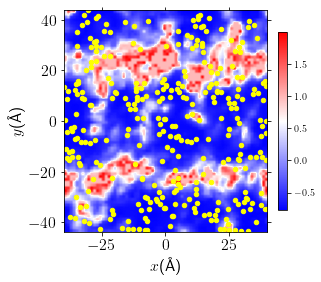

In [268]:
def PltBitmapWithScatter( value, xyScatter,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              ticklabels=True,
              color='black',
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4*aspect))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16)
    ax.tick_params(labelsize=16,which='both',axis='both', top=True, right=True)
    if not ticklabels:
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=color,marker='o',s=20)
        
        
    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    


def PlotDminVor( lmpData, lmpDmin, times,
                   title='d2min',
               ):
    
    for itime in sorted(times):
#         pdb.set_trace()
        #--- dmin
        (xlin, ylin, zlin), junk, d2intrp = Intrp(lmpDmin, 
                                            times = [itime],
                                            time0 =0,
                                            Plot = None,
                                           )
#         pdb.set_trace()
        #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp[itime].d2min].reshape(((ny,nx,nz)))



        #--- icosahedra
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
        
        #--- map
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        mapp = lp.Map( vor, box ) 
        mapp.ChangeBasis()
        mapp.Set( vor ) #--- atoms: add mapped xyz

        #--- filter
        indices = GetFullIcosahedra( vor )
        dz = zlin[-1]-zlin[-2]
        dz *= 1.25
        lz = zlin[-1]-zlin[0]
        zc=0.5*(zlin[0]+zlin[-1])+10*dz
        zlo=(zc-dz-zlin[0]) % lz + zlin[0]
        zhi=(zc+dz-zlin[0]) % lz + zlin[0]
        
#        print(zlo,zc,zhi)
#        pdb.set_trace()
        indxx= np.all([vor.zm > zlo, 
                       vor.zm < zhi
                      ],
                        axis=0)
        indxx = np.all([indxx,indices],axis=0)

                #--- xy plane
        
        val = value[:,:,int(nz*(zc-zlo)/lz)].copy()

        #
        PltBitmapWithScatter(val, 
                      np.c_[np.array(vor.xm)[indxx],np.array(vor.ym)[indxx]],
                      xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                      xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                      zscore = True,
                      frac = 1.0, #--- plot a patch
                      title = '%s%s.png'%(title,itime),
                      colorbar=None,
                      ticklabels = None,
                      color='black',
 #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                      )

    
if DminAnalysis and VorAnl:

#     PlotDminVor( lmpVor, lmpDmin, 
#                  times = [itime], #[2000000],#list(lmpData.coord_atoms_broken.keys()),
#                 title='d2minBad',
#                )

    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))

    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    d2min, box, 'd2min',
                    vor,
                    times = [itime],
                    time0 =0,
                    Plot = True,
                    title='scatterD2minRhoGood.png'
                   )
    

## SRO density

InputFile= junk.xyz
num_frames= 1
frame=0


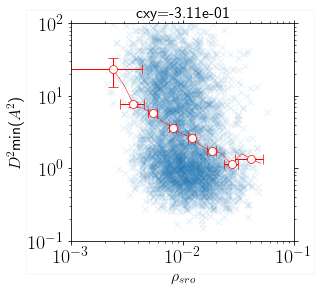

In [666]:
if DminAnalysis and VorAnl:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  vor, d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                axisLabels = True,
                xlim=(1e-3,1e-1,1e-1,1e2),
                title = 'scatterD2minRhoGood.png', 
                )                      
                      
    #--- save
    strn = GetStrain(lmpData, 
                     times = [itime], #list(lmpData.coord_atoms_broken.keys()), 
                     time0 = 0 )
    np.savetxt('crsD2minRhoSro.txt',
               np.c_[valuesDict(strn,strn.keys()), valuesDict(crs,crs.keys())], 
               header='gamma\tCrltnCoeff')


In [609]:
pd.DataFrame(vor.__dict__).head()

,x,y,z,id,type,VoronoiIndex1,VoronoiIndex2,VoronoiIndex3,VoronoiIndex4,VoronoiIndex5,VoronoiIndex6,VoronoiIndex7,VoronoiIndex8,VoronoiIndex9,IcoTrue,AtomicVolume
0,14.2073,-10.2949,-43.1558,1.0,4.0,0.0,0.0,0.0,5.0,4.0,4.0,0.0,0.0,0.0,False,12.485599
1,-13.821,-18.8449,-7.82422,2.0,2.0,0.0,0.0,0.0,2.0,8.0,2.0,0.0,0.0,0.0,False,11.256979
2,42.243198,-16.912701,11.0364,3.0,1.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,False,11.979787
3,-31.166401,-21.8507,-17.913601,4.0,2.0,0.0,0.0,0.0,2.0,8.0,3.0,0.0,0.0,0.0,False,11.748718
4,-9.832831,20.899099,16.6938,5.0,2.0,0.0,0.0,0.0,0.0,12.0,2.0,0.0,0.0,0.0,False,12.581769


### multiple systems

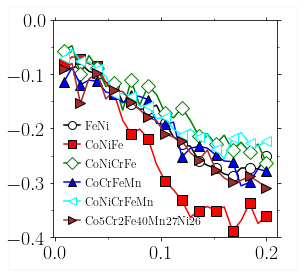

In [237]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\langle D^2_{min} . \rho_{sro}\rangle$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_ylim(-0.4,0)
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                         'CoCrFeMn/Run0', 'CoCrFeMn/Run1', 'CoCrFeMn/Run2'
                                         'FeNi/Run0',
                                         'CoNiFe/Run0',
                                        'CoNiCrFe/Run2',
                                         'CoCrFeMn/Run0', 
                                         'CoNiCrFeMn/Run1', 
                                        'Co5Cr2Fe40Mn27Ni26/Run0'
                                        ],markers, colors, fillstyles )):
        try:
            sarr  = np.loadtxt('d2minRatio%s/crsD2minRhoSro.txt'%GlassType)
            #--- fliter
            ydata = sarr[:,1] #--- first 2nd col is stress drop
            xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
        #
            ax.plot(xdata[1:],ydata[1:],
                    linestyle='-',
                    markersize=10,
                    color=color,
                    marker=marker,
                    markerfacecolor=fillstyle,
                    markeredgecolor='black' if not fillstyle else None,
                    markevery=int(len(xdata)/10),
                    label = '%s'%GlassType[0:-5])
        except:
            continue
    #
    ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('cxyGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### h and cxy

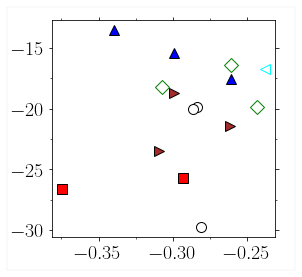

In [227]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_ylabel(r'$h$',fontsize=20)
#     ax.set_xlabel(r'$\langle D^2_{min} . \rho_{sro}\rangle$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                         'CoNiFe',
                                        'CoNiCrFe',
                                         'CoCrFeMn', 
                                         'CoNiCrFeMn', 
                                        'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):
        for irun in range(3):
            try:
                sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
                hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
                #--- fliter
                xdata = sarr[:,1] #--- first 2nd col is stress drop
                #xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
                cxy = np.mean(xdata[-1-8:-1]) #--- mean of the last 10 points
                #--- %95 quantile 
                xdata.sort()
                n=len(xdata)
                cxy = xdata[int(.05*n):][0]
            #
                ax.plot(cxy,-hmodu,
#                         linestyle='-',
                        markersize=10,
                        color=color,
                        marker=marker,
                        markerfacecolor=fillstyle,
                        markeredgecolor='black' if not fillstyle else None,
#                         markevery=int(len(xdata)/10),
                        label = '%s'%GlassType)#[0:-5])
            except:
#                traceback.print_exc()
                continue
    #
#     xx=np.array(list(map(lambda x: x.get_xdata(),ax.lines))).flatten()
#     yy=np.array(list(map(lambda x: x.get_ydata(),ax.lines))).flatten()
#     xx-=np.mean(xx)
#     xx/=np.std(xx)
#     yy-=np.mean(yy)
#     yy/=np.std(yy)
#     print(np.sum(xx*yy)/len(xx))
#     coeff = np.polyfit(xx,yy,deg=1)
#     def f(x,m,c):
#             return m*x+c
#     ax.plot(xx,f(xx,*coeff),'-.r')
#    ax.legend(frameon=False, fontsize=12)
#     #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('hCxy.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# Local Moduli

## parse data

In [320]:
def GetAtoms( filee, nevery = 1 ):
    lmpData = lp.ReadDumpFile( filee )
    lmpData.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[1]':'sxx','c_peratom[2]':'syy','c_peratom[3]':'szz',
                                                       'c_peratom[4]':'sxy','c_peratom[5]':'sxz','c_peratom[6]':'syz'}
                    )
    nn=len(lmpData.coord_atoms_broken.keys())
    itimee=list(lmpData.coord_atoms_broken.keys())[0:nn:nevery]

    #--- volume
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    !ovitos OvitosCna.py $filee Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3  
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)
    #--- atom obj
    box0 = map(lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] ) ), itimee ) #--- reference state
    atoms0 = map(lambda x: lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series'),
                        AtomicVolume = ovtData.coord_atoms_broken[x]['AtomicVolume'].tolist()), itimee )

    return dict(zip(itimee,list(atoms0))), dict(zip(itimee,list(box0)))

def GetTimeAverageSeries( atoms, col='x' ):
    sarr = np.array(list(map( lambda x: atoms[x][col], atoms.keys() ))).T
    return np.mean(sarr,axis=1)

def GetTimeAverageAtom( atoms0 ):
#    pdb.set_trace()
    itime0 = list(atoms0.keys())[0]
    attrs=atoms0[itime0].__dict__.keys()
    #
    sarr = np.array(list(map(lambda x: GetTimeAverageSeries( atoms0, col=x ), attrs))).T
    df = pd.DataFrame(sarr,columns=attrs)
    #--- pbc: mean of x is not valid! set it to initial values
#    pdb.set_trace()
    df.x = atoms0[itime0]['x'].to_list()
    df.y = atoms0[itime0]['y'].to_list()
    df.z = atoms0[itime0]['z'].to_list()
    #---
    sdict= df.to_dict(orient='series')    
    atomi=lp.Atoms(**sdict)
#    pd.DataFrame(atomi.__dict__)
    return atomi

if ModuAnl:
    #--- read initial atomic positions/stresses
    atomi, boxi = GetAtoms( '%s/itime200/dump_init.xyz'%path, nevery = 1 ) #--- change it to 1
    atoms0 = GetTimeAverageAtom( atomi ) #--- argument: dic with key: time and val: atom object
    #
    itime0 = list(atomi.keys())[0]
    box0=boxi[itime0]
    #
    atomd = {}
    boxd = {}
    ebulk = {}
    #--- read data for deformed configurations
    #for dirr, mode in zip(range(1,7),['xx','yy','zz','yz','xz','xy']):
    for dirr, mode in zip([6],['xy']):
        atomt, boxt = GetAtoms( '%s/itime200/dump_def%s.xyz'%(path,dirr), nevery=1 )
        atomt.pop(0) #--- time 0 is not equilibrated!
        atomd[mode] = GetTimeAverageAtom( atomt )
        #
        itime0 = list(atomt.keys())[0]
        boxd[mode] = boxt[itime0]
        #
        #--- evaluate strain
        if dirr == 1 or dirr == 2 or dirr == 3:
            indxi = dirr - 1
            indxj = dirr - 1
        elif dirr == 6: #--- xy
            indxi = 0
            indxj = 1
        dx=boxd[mode].CellVector[indxi,indxj]-box0.CellVector[indxi,indxj]
        l0=box0.CellVector[indxj,indxj]        
        ebulk[mode] = dx/l0    
    ebulk['yz']=ebulk['xz']=ebulk['xy']
    ebulk

InputFile= /Users/Home/Desktop/Tmp/txt/itime200/dump_init.xyz
num_frames= 21
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
InputFile= /Users/Home/Desktop/Tmp/txt/itime200/dump_def6.xyz
num_frames= 21
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20


## elastic constants

In [322]:
if ModuAnl:
    cfac = 1.0e-4 #--- bar to gpa
    dxx={}
    dyy={}
    dzz={}
    dyz={}
    dxz={}
    dxy={}
    for mode in ['xy']: #['xx','yy','zz','yz','xz','xy']:
        dxx[mode]=(atomd[mode].sxx/atomd[mode].AtomicVolume-atoms0.sxx/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dyy[mode]=(atomd[mode].syy/atomd[mode].AtomicVolume-atoms0.syy/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dzz[mode]=(atomd[mode].szz/atomd[mode].AtomicVolume-atoms0.szz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dyz[mode]=(atomd[mode].syz/atomd[mode].AtomicVolume-atoms0.syz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dxz[mode]=(atomd[mode].sxz/atomd[mode].AtomicVolume-atoms0.sxz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dxy[mode]=(atomd[mode].sxy/atomd[mode].AtomicVolume-atoms0.sxy/atoms0.AtomicVolume)/ebulk[mode]*cfac

### output dump

In [330]:
if ModuAnl:
    df=pd.DataFrame(atoms0.__dict__)
    cols = list(df.keys())+['C66'] # + ['C55'] + ['C44']#--- C66 is cxyxy
    df = pd.DataFrame(np.c_[df,dxy['xy'],
    #                        dxz['xz'],
    #                        dyz['yz']
                           ],
                      columns=cols)
    atomm = lp.Atoms(**df)
    wd = lp.WriteDumpFile(atomm, box0)
    wd.Write('dump.xyz',
             attrs=['id', 'type','x', 'y', 'z', 'sxx', 'syy', 'szz', 'sxy', 'sxz', 'syz',
                   'AtomicVolume', 'C66'],
             fmt='%i %i %15.14e %15.14e %15.14e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e')
    os.system('tar czf dump.gz dump.xyz')

#### append

In [61]:
if not RemoteMachine:
    try:
        os.system('rm Modu.xyz')
    except:
        pass
    for i in range(200):
        os.system('tar xzf FeNiT300Elasticity%s/Run1/dump.gz'%(i))
        os.system('cat dump.xyz >> Modu.xyz')
#        os.system('cat FeNiT300Elasticity%s/Run1/dump.xyz >> Modu.xyz'%(i))

tar: Error opening archive: Failed to open 'FeNiT300Elasticity118/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity130/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity131/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity132/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity133/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity134/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity135/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity136/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity137/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity139/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity140/Run1/dump.gz'
tar: Error opening archive: Failed to open 'FeNiT300Elasticity166/Run1/dump.gz'
tar: Error opening archive: Failed to op

### map

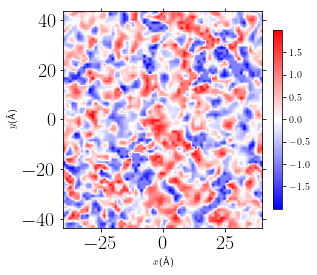

In [331]:
if ModuAnl:
    junk, (xv, yv, zv), d2intrp = Intrp(atomm, box0, 'C66',
                    times = [0],
                    time0 =0,
                    Plot = True,
                    title='mapCxyxy.png'
                   )

## D2min 

In [391]:
if ModuAnl:
    #--- d2min associated with the perturbed states
    refs='%s/itime200/dump_init.xyz'%path
    curr='%s/itime200/dump_def%s.xyz'%(path,6)
    !rm 'd2min.xyz'
    !ovitos OvitosCna.py $curr 'd2min.xyz' 1 2 $refs
    #--- read from d2min.xyz
    lmpDmin = lp.ReadDumpFile( 'd2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

InputFile= /Users/Home/Desktop/Tmp/txt/itime200/dump_def6.xyz
num_frames= 21
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20


### average 

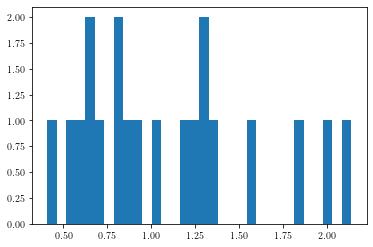

In [405]:
#slist=[]
atoms={}
for key in lmpDmin.coord_atoms_broken.keys():
    if key ==0:
        continue
    atoms[key] = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
    slist += [atoms[key]['d2min'].iloc[0]]
#plt.hist(slist,bins=32)
#plt.show()
d2min = GetTimeAverageAtom( atoms )

### Spatial map 

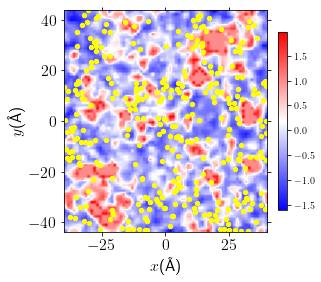

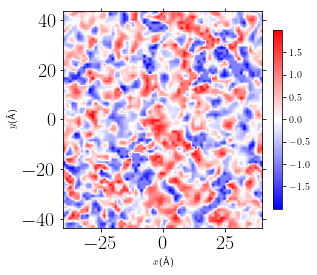

In [417]:
#---

(xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                d2min, box0, 'd2min',
                vor,
                Plot = True,
                title='scatterD2minRhoGood.png'
               )
    
junk, (xv, yv, zv), d2intrp = Intrp(atomm, box0, 'C66',
                Plot = True,
                title='mapCxyxy.png'
               )

### correlation function

In [ ]:
if ModuAnl:
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[mu_intrp.C66].reshape((ny,nx,nz))
    Crltn = GetAutoCorrelation( value )
    #
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
    #--- xy plane
    val = Crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_mu.png',
              dpi = 60
            )
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_mu.png',
                 title = '',
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    #--- bulk strain
    dx=box0.CellVector[0,1]
    l1=box0.CellVector[1,1]
    ebulk = dx/l1
    #--- save
    np.savetxt('mu_length.txt',np.c_[ebulk,xc,yc],header='strain\txc\tyc')
    xc,yc

#### multiple files

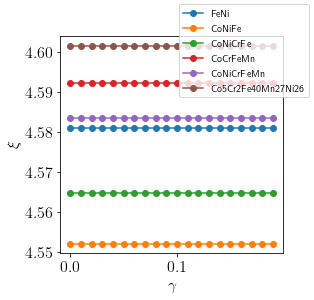

In [499]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylabel(r'$\xi$',fontsize=16)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))

        sarr = np.loadtxt('mu_size.txt')
        ax.plot(sarr[:,0],0.5*(sarr[:,2]+sarr[:,1]),'-o',label=mg)
    #
    fig.legend()
    plt.savefig('crltnMuLength.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


##### length and hmin

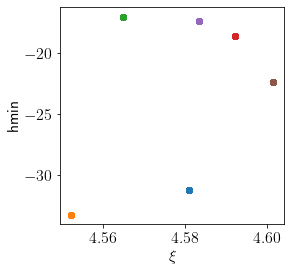

In [444]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'$\xi$',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/NegativeModulus.txt >> hmin.txt'%(mg,i))
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        ax.scatter(0.5*(sarr[:,2]+sarr[:,1]),-hmin[:,1],marker='o',label=mg)
    #
#    fig.legend()
    plt.savefig('crltnMu.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


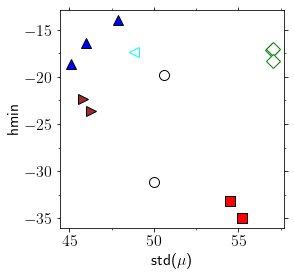

In [87]:
if not RemoteMachine:
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
    ax.set_xlabel(r'std($\mu$)',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for itimee in range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/NegativeModulus.txt'%pathh
                file1 = '%s/mu_mean_std.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
                    os.system('cat %s >> hmin.txt' %file0 )
                    os.system('cat %s >> mu_size.txt'%file1)
                
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        if len(sarr.shape) == 2:
            slope = -hmin[:,1]
            std_mu = sarr[:,2]
            mean_mu = sarr[:,1]
        elif len(sarr.shape) == 1:
            slope = -hmin[1]
            std_mu = sarr[2]
            mean_mu = sarr[1]

        #
        ax.plot(std_mu,slope,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%mg)
        # 
#    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
#     #
    plt.show()


## Crltns with SRO
### scatter map 

77 77


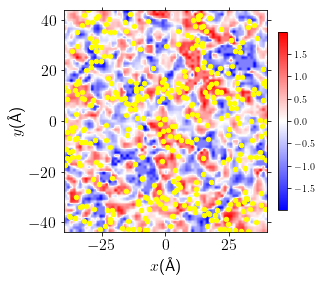

In [618]:
if ModuAnl:
    #--- voronoi data
#    !ovitos OvitosCna.py 'dump.xyz' 'Voronoi.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5  
#    lmpVor = lp.ReadDumpFile( 'Voronoi.xyz' )
#    lmpVor.GetCords( ncount = sys.maxsize)
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[0].to_dict(orient='series') )
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    atomm, box0, 'C66',
                    vor,
                    Plot = True,
                    title='mapCxyxySro.png'
                   )

### scatter mu and sro

InputFile= junk.xyz
num_frames= 1
frame=0


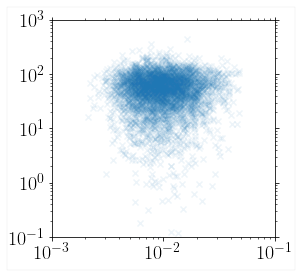

In [675]:
if ModuAnl:

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #--- density of SROs: see PRB draft
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    atomm.tmp = atomm.C66
    #
    ScatterXY(  vor, atomm,
                Plot = True, 
                PLOT_AVERAGE = None,
                xlim=np.array([1e-3,1e-1,1e-1,1e3]),
                title = 'scatterModuRho.png',
                axisLabels=(r'$\rho_{sro}$',r'$\mu$'),
                )            
    
    
#    (xlin, ylin, zlin), (xv, yv, zv), rho_intrp = 
#    Intrp(vor, box, 'tmp',
#                Plot = True,
#               )

#### gr

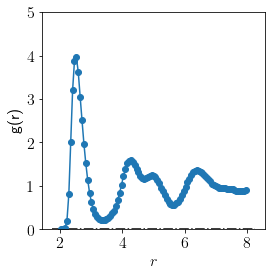

In [818]:
def PltErr( xdata, ydata, err,
            xstr = r'$r$',
            ystr = r'$c(r)$',
            ylim=[-.2,.5],
            title='junk.png'
            ):
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xstr,fontsize=16)
    ax.set_ylabel(ystr,fontsize=16)
    ax.tick_params(labelsize=16)
#
    ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
#--- plot
#    ax.legend(frameon=False)
#    ax.set_title( title )
    #ax.set_yscale('log')
    #
    ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
#    ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
    #
#        ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #
    plt.savefig(title,dpi=dpi,bbox_inches='tight')
    plt.show()
    
    

box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
neigh = lmpNeigh.coord_atoms_broken[itime]


rdf = lp.ComputeRdf(  atoms, box )
rdf.PairCrltn( nbins = 100, 
              bins=np.linspace(2.0,cutoff,100), 
              rlist=neigh.DIST )
bin_edges, hist, err = rdf.Get()

#--- plot
#plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')

PltErr(bin_edges,hist,err,
      ylim=[0,5],
       ystr='g(r)',
       title='gr.png'
      )

In [755]:
def FilterDataFrame(df,key='id',val=[1,2,3]): #,out='C66'):
    tmp0 = df.set_index(key,drop=True,append=False).loc[val] 
    return tmp0.reset_index() #.reindex(range(len(tmp0)))
    

#### mean mu.rho

In [819]:
#--- compute product using the neighbor list

icoFiltr = vor.id[ vor.tmp > 0.0 ] #--- atom id with ico. symmetry
neigh_filtrd = FilterDataFrame(neigh,key='id',val=icoFiltr) #--- filter neighbor list

#--- ij pairs
atomiIds = np.array(neigh_filtrd.id)
atomjIds = np.array(neigh_filtrd.J,dtype=int)

# #--- product of rho and mu
df_vor=pd.DataFrame(vor.__dict__)
df_mod = pd.DataFrame(atomm.__dict__)

#--- zscore
df_vor_filtrd = FilterDataFrame(df_vor,key='id',val=atomiIds)
df_mod_filtrd = FilterDataFrame(df_mod,key='id',val=atomjIds)

x = np.array(df_vor_filtrd['tmp'])
y = np.array(df_mod_filtrd['C66'])

prod = Zscore(x) * Zscore(y)

#### mean vs r.

(915045,)
(915045,)


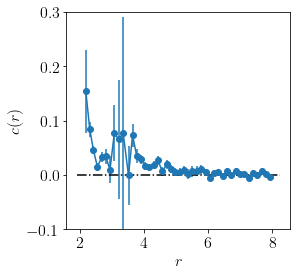

In [828]:
crltn = lp.ComputeCrltn(  atoms, box, 
                          atomm.C66, #--- values
                          dx = 0.13)
crltn.AutoCrltn(RADIAL = True, 
                rlist = neigh_filtrd.DIST,
                rvect = np.c_[neigh_filtrd[['DX','DY','DZ']]],
                flist = prod,
               )
rv, hist, err = crltn.Get()
PltErr(rv,hist,err,      
       ylim=[-.1,.3],
       title='crMuRho.png'
      )

### kde

(nx,ny,nz)= (77, 69, 77)
77 77


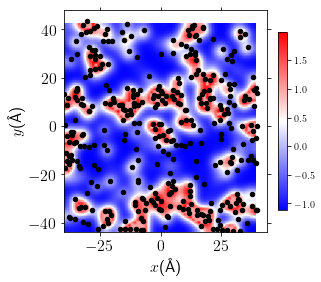

rho.shape= (77, 69, 77)


In [551]:
if ModuAnl:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[2000000], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[2000000].to_dict(orient='series') )
    #
    mapp = lp.Map( vor, box ) 
    mapp.ChangeBasis()
    mapp.Set( vor ) #--- atoms: add mapped xyz
    #--- filter icosahedral atoms
    icoFiltr = GetFullIcosahedra( vor )
    #--- kde density
    rho = DensityMap(vor, icoFiltr, xlin, ylin, zlin )
    print('rho.shape=',rho.shape)

#### cross crltn

In [527]:
if ModuAnl:

    mu_reshaped = np.array(mu_intrp.C66).reshape(xv.shape)
    print('mu.shape=',mu_reshaped.shape)

    (nx,ny,nz)=list(map(len,[xlin, ylin, zlin]))

    rhoq = np.fft.fftn( Zscore( rho ) )
    muq = np.fft.fftn( Zscore( mu_reshaped ) ) #mu_reshaped ) )

    crq=rhoq.conjugate() * muq
    cr = np.fft.ifftn(crq) / (nx*ny*nz)

    assert np.abs(cr.imag).max() < 1.0e-10, 'inverse is not real!'


mu.shape= (77, 69, 77)


#### Plot

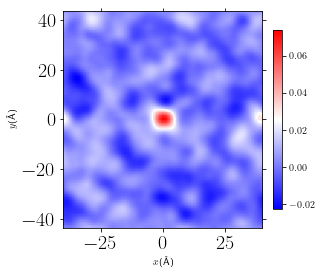

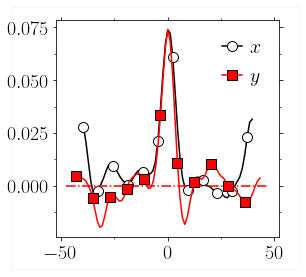

In [549]:
if ModuAnl:

    cr_shift = np.fft.fftshift(cr)

    val = cr_shift[:,:,int(nz/2)]
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )

    PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = None,
                  frac = 1.0, #--- plot a patch
                  title = 'crMapModu.png',
                  colorbar=True,
                )
    
    PltCrltnFunc(   cr, 
                     xv,yv,
                     fileName = 'crxyModu.png',
                     title = '', #r'$\gamma=%3.2f$'%(ebulk),
                     cTOL = 1.0e-2,
                     dpi = 150,
                     symmetry = False,
                    )

In [676]:
# def GetSroDensity(vor,box):
#         indices = GetFullIcosahedra( vor )

        
#         #--- output dump file (apply filtering), run ovitos
#         atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
#         #
#         wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
#         wdf.Write('junk.xyz')
#         #--- load to ovitos
#         rad1=0.0#AtomicRadius[1]
#         rad2=0.0#AtomicRadius[2]
#         rad3=0.0#AtomicRadius[3]
#         rad4=0.0#AtomicRadius[4]
#         rad5=0.0#AtomicRadius[5]
#         !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
#         #--- read from ovito output
#         lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
#         lmpDataFiltrd.GetCords( ncount = sys.maxsize )
#         #
#         vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
#         x = 1.0/np.array(vorFiltrd.AtomicVolume)
        
#         return indices, x
    
# def sroDensityField( d2min, box, attr, vor,
#                     AtomicRadius,     
#                   Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
#                  axisLabels = True,
#                  **kwargs,
               
#                 ):
        
#         icoFiltr, icoRho = GetSroDensity(vor,box) #--- icoFiltr: true if atom has icosahedral symmetry
        
#         #--- filter d2min        
#         y = lp.Atoms(**pd.DataFrame(d2min.__dict__)[icoFiltr].to_dict(orient='series'))
#         y = np.array(y[attr])

#         #--- filter atoms
#         assert icoRho.shape == y.shape
        
#         icoRho = icoRho[y>0.0]
#         y = y[y>0.0]
        
#         #--- cross crltn.
#         x = icoRho
#         if 'zscore' in kwargs and kwargs['zscore']:
#             x = Zscore(x)
#             y = Zscore(y)
        
#         crs[itimee] = CrssCrltn( np.log10(x.copy()), np.log10(y.copy()) )
        
#         if Plot:
#             fig = plt.figure(figsize=(4,4))
#             ax = fig.add_subplot(111)
#             #
#             ax.scatter(x,y,marker='x',alpha=0.08)
#             if PLOT_AVERAGE:
#                 xb, yb, err_x, err_y = GetBinnedAverage( x, y, nbins_per_decade = 8 )
#                 nevery = int(np.ceil(len(xb)/10.0))
#                 ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
#                     fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
#                             markeredgecolor='red', markevery=nevery, errorevery=nevery,
#                     linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)

#             if 'xlim' in kwargs:
#                 ax.axis(kwargs['xlim'])
#     #        makeTickLabels(ax, x, y)
#             #
#             ax.set_yscale('log')
#             ax.set_xscale('log')
#             #
#             if axisLabels:
#                 ax.set_ylabel(r'$\mu$',fontsize=16)
#                 ax.set_xlabel(r'$\rho_{sro}$',fontsize=16)
#                 #
# #                ax.set_title(r'cxy=%3.2e'%crs[itimee],fontsize=16)
#                 #
#     #        ax.legend(frameon=False, fontsize=12)
#             #
#             ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#             DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_X=True,LOG_Y=True) 
#             #
#             plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#             plt.show()
        
#         return icoFiltr



# if DminAnalysis and VorAnl:    
    
#     #--- sro density based on voronoi volumes
#     icoFiltr = sroDensityField( 
#                         atomm, box0, 'C66',
#                         vor,
#                        AtomicRadius=AtomicRadius,
#                        Plot = True, 
#                        PLOT_AVERAGE = None,
#                        axisLabels = True,
#                        title = 'scatterMuSro.png', 
#                         zscore = None,
#                            )


## Distributions

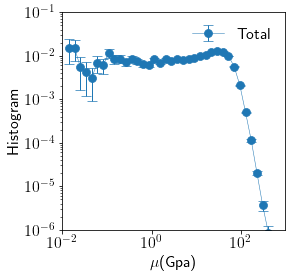

In [386]:
def Pdf( value, ax,  label='',n_per_decade=32, Error = True, density=True, linscale=True,
             ):
    #--- size distribution
#    while True:
    hist, edges2, error = GetPDF( value, linscale = linscale, n_per_decade=n_per_decade,density=density)
#        if not np.all(error==1.0) or n_per_decade <= 1:
#            break
#        n_per_decade /= 2
#    print(list(zip(hist,error)))
#
#    np.savetxt('data_annealed.txt',np.c_[edges2,hist,error])
#    print(np.sum(hist))
    if not Error:
        error *= 0.0 
    ax.errorbar(edges2,hist,error,fmt='-o',
                    markersize=8,markeredgewidth=0.7,
                        linewidth=.5, zorder=1,
                         barsabove=None,capsize=5,capthick=1,elinewidth=1,label=label)
    #--- fit
#     dy = error/hist
#     dy = dy[edges2>0]
#     y=np.log10(hist[edges2>0])
#     x=edges2[edges2>0]
#     z=np.polyfit(x,y,1)#,w=1.0/dy)
    
    
# #    print(z)
#     def func(x,a,b):
#         return a*x+b
        
    
#     ax.plot(x,10**func(x,z[0],z[1]),'-.',color='red',label='m=%2.1e'%z[0])
    
    
if ModuAnl:

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-6,1e-1)
    ax.set_xlim(1e-2,1e3)
    #ax.set_xlabel(r'$(p-\bar{p})\times w^{3/2}$',fontsize=16)
    ax.set_xlabel([r'$(p-\bar{p})/\sigma_p$',r'$\mu$(Gpa)'][1],fontsize=16)
    ax.set_ylabel(r'Histogram',fontsize=16)
    ax.tick_params(labelsize=16)
    #ax.set_title(r'itime=%s'%itime)
    #--- fit        
    x=np.linspace(-4,4,1000)
    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #
    var={}
    iitype=1 #--- Ni
    Pdf( atomm.C66[atomm.C66>0.0], #(atomm.C66+atomm.C55+atomm.C44)/3.0, #-np.mean(value))/var[key], 
          ax,
         label = 'Total',
        density=True,
        linscale=False,
        n_per_decade=8,
        )

#     Pdf( atomm.C66[icoFiltr],
#          ax,
#          label = 'Icosa',
#         density=None,
#        )
    mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
    mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()
#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    #plt.plot(x,y,'.-',color='black',zorder=2)
    ax.legend(frameon=False, fontsize=16)
    plt.savefig('pdf.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    #--- bulk strain
    dx=box0.CellVector[0,1]
    l1=box0.CellVector[1,1]
    ebulk = dx/l1
    #
    np.savetxt('mu_mean_std.txt',np.c_[ebulk,mu,mu_std],header='strain\tmu\tmu_std')



### multiple systems

X.shape= (200, 3)
xm.shape= (200,)


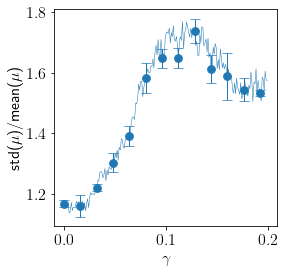

In [842]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylabel(r'std($\mu$)/mean($\mu$)',fontsize=16)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
#                 'CoNiFe',
#                 'CoNiCrFe',
#                 'CoCrFeMn',
#                 'CoNiCrFeMn',
#                 'Co5Cr2Fe40Mn27Ni26'
                ]:
        #----------------------
        #--- concatenate data
        #----------------------
        sarr = {}
        for irun in range(3): #--- realizations

            try:
                os.system('rm mu_mean.%s.txt'%irun)
            except:
                pass
            for i in range(0,200,1): #--- multiple strains
                os.system('cat %sT300Elasticity%s/Run%s/mu_mean_std.txt >> mu_mean.%s.txt'%(mg,i,irun,irun))

            sarr[irun] = np.loadtxt('mu_mean.%s.txt'%irun)
        #----------------------    
        #--- average
        #----------------------
        X = np.array(list(map(lambda x:sarr[x][:,0], range(3)))).T
        y = np.array(list(map(lambda x:sarr[x][:,1], range(3)))).T
        y1 = np.array(list(map(lambda x:sarr[x][:,2], range(3)))).T
        print('X.shape=',X.shape)

        xm, ym, yerr = GetAverage( X, y1/y, nbins=1024 )
        print('xm.shape=',xm.shape)
        #--- plot
        markevery = int(len(xm)/12)
        ax.errorbar(xm,ym,yerr,fmt='-o',
                    errorevery=markevery,
                    markevery=markevery,
                        markersize=8,markeredgewidth=0.7,
                            linewidth=.5, zorder=1,
                             barsabove=None,capsize=5,capthick=1,elinewidth=1,label=mg)

    
    # #    fig.legend()
    plt.savefig('varMu.png',dpi=75,bbox_inches='tight')
#     #
    plt.show()

### scale dependence
#### partition

In [527]:
if ModuAnl:
    #--- length scales
    nn=[list(set(np.logspace(5,1,16,base=2,dtype=int))),
        list(set(np.logspace(6,1,32,base=2,dtype=int)))
       ][0]
    nn.sort()
    nn=nn[:-1][:-1]

    #clist, plist = GetPressComp( atoms,box, 20.0 )
    #--- partition
    rsub = [
            [10,15],
            list(map(lambda x: box0.CellVector[0,0]/x,nn))
           ][1]
    print('rsub=',rsub)
    rsub = rsub
    # #--- composition and pressure fluctuations
    # cplist = list(map(lambda x: GetPressComp( atoms,box, x ), rsub))



rsub= [39.9617, 26.641133333333332, 19.98085, 15.98468, 13.320566666666666, 11.41762857142857, 9.990425, 7.99234, 6.660283333333333, 5.328226666666667, 4.440188888888889, 3.632881818181818]


In [528]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    for typei in types:
        c[typei] = 1.0*np.sum(atoms.type == typei)/n

    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    nx -= 1
    ny -= 1
    nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.C66)*np.array(x.AtomicVolume)))*(1/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
    plist = list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        display(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist

if ModuAnl:
    cplist=list(map(lambda x: GetPressComp(atomm,box0,x), rsub))

    cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list


39.9617 8
26.641133333333332 27
19.98085 64
15.98468 125
13.320566666666666 216
11.41762857142857 343
9.990425 512
7.99234 1000
6.660283333333333 2028
5.328226666666667 3840
4.440188888888889 6498
3.632881818181818 11638


##### Plot

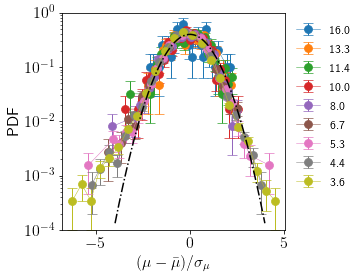

In [645]:
if ModuAnl:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylim(1e-4,1)
    # ax.set_xlim(1e-2,1e4)
    #ax.set_xlabel(r'$(p-\bar{p})\times w^{3/2}$',fontsize=16)
    ax.set_xlabel([r'$(\mu-\bar{\mu})/\sigma_\mu$',r'$\mu$(Gpa)'][0],fontsize=16)
    ax.set_ylabel(r'PDF',fontsize=16)
    ax.tick_params(labelsize=16)
    #--- fit        
    x=np.linspace(-4,4,1000)
    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #
    var={}
    mean={}
    kurt = {}
    for key in list(cplist.keys())[3:]:
        slist = cplist[key][1]
        #
        var[key]=np.std(slist)
        mean[key]=np.mean(slist)
        var[key]/=mean[key]
        kurt[key] = kurtosis(slist)
        #--- rescale
        slist -= np.mean(slist)
        slist /= np.std(slist)
        #
        Pdf( slist, 
         ax,
         label = '%3.1f'%key,
         Error = True,
       )

#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    plt.plot(x,y,'-.',color='black',zorder=2)
    ax.legend(frameon=False, fontsize=12,bbox_to_anchor=(1,1))
    plt.savefig('pdfMuRescaled.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    

#### variance

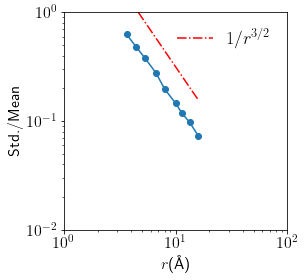

In [646]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
ax.set_ylabel(r'Std./Mean',fontsize=16)
ax.tick_params(labelsize=16)
ax.axis([1e0,1e2,1e-2,1e0])
#ax.axis([1e0,1e3,1e-3,1e0])
PutMinorTicks(ax, LOGY=True,LOGX=True)
#
ax.plot(list(var.keys()),list(map(var.get,var.keys())),'-o')
#
xx=np.array(list(var.keys()))
xx.sort()
ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
#
ax.legend(frameon=False,fontsize=18)
#
plt.savefig('var.png',dpi=75,bbox_inches='tight')
plt.show()

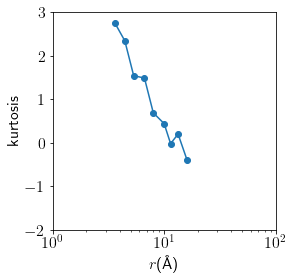

In [647]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
ax.set_ylabel(r'kurtosis',fontsize=16)
ax.tick_params(labelsize=16)
ax.axis([1e0,1e2,-2,3])
#PutMinorTicks(ax, LOGY=True,LOGX=True)
#
ax.plot(list(kurt.keys()),list(map(kurt.get,kurt.keys())),'-o')
#
# xx=np.array(list(var.keys()))
# xx.sort()
# ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
#
#ax.legend(frameon=False,fontsize=18)
#
plt.savefig('kurt.png',dpi=75,bbox_inches='tight')
plt.show()

In [503]:
pd.DataFrame(atomm.__dict__).head()

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume,C66,xm,ym,zm
0,4.537,-1.508,-13.35,1.0,2.0,-1.974929e+06,-1.361510e+05,-202544.285714,160840.000000,-8.523286e+05,634241.714286,11.160377,107.964647,4.537,-1.508,-13.35
1,39.600,-18.000,28.50,2.0,4.0,1.532138e+06,1.418151e+06,515495.238095,284281.904762,1.064438e+06,373338.571429,13.072213,-26.543242,39.600,-18.000,28.50
2,11.430,-7.231,-12.60,3.0,2.0,-1.630190e+06,-2.140257e+06,-309480.952381,-774061.904762,-1.451243e+06,76004.285714,11.075108,-27.906907,11.430,-7.231,-12.60
3,59.080,7.579,-17.71,4.0,2.0,2.148205e+05,7.677095e+05,-377562.380952,27086.190476,7.605095e+05,537878.571429,11.929944,11.922573,59.080,7.579,-17.71
4,-6.356,37.420,-14.18,5.0,4.0,3.154152e+05,9.152371e+05,720131.904762,650500.000000,-9.258810e+05,-211904.285714,12.617178,20.610171,-6.356,37.420,-14.18


# Local Order Analysis

In [362]:
if CommonNeighAnl and not Ovitos:
    if not TimeSeries:
        #--- extract atom and box properties
        cna = lp.Atoms( **lmpCna.coord_atoms_broken[itime].to_dict(orient='list') )
    else:
        cna = {}
        for iitime in lmpCna.coord_atoms_broken:
            cna[iitime] = lp.Atoms( **lmpCna.coord_atoms_broken[iitime].to_dict(orient='list') )

if CommonNeighAnl and Ovitos:            
    !ovitos OvitosCna.py $fileName Cna.xyz $nevery 0

InputFile= /Users/Home/Desktop/Tmp/txt/FeNi_glass.dump
num_frames= 201


In [364]:
#--- read from d2min.xyz
if CommonNeighAnl and Ovitos:
    lmpData = lp.ReadDumpFile( 'Cna.xyz' )
    lmpData.GetCords( ncount = sys.maxsize)

## Histograms

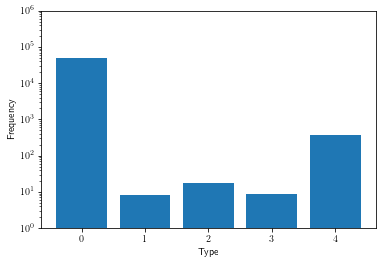

In [365]:
if CommonNeighAnl and not TimeSeries:
    cna = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    #
    plt.yscale('log')
    plt.ylim(1,1e6)
    plt.xlabel('Type')
    plt.ylabel('Frequency')
    #
    x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
    #
    count=np.zeros(5,dtype=int)
    for typee in x:
        count[int(typee)] = y[int(typee)]
    #
    plt.bar(x, count)
    #
    plt.show()
    #--- strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = np.array([dx/l1])

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.concatenate([ebulk,count]).reshape((1,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


## output timeseries

In [378]:
if CommonNeighAnl:
    #
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    ntime = len(times)
    ebulk = np.zeros( ntime )
    Count = np.zeros(ntime*5).reshape((ntime,5))
    #
    for iitime, indxx in zip(times,range(ntime)):
        cna = lp.Atoms( **lmpData.coord_atoms_broken[iitime].to_dict(orient='list') )
        #
        x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
        #
        for typee, count in zip(x,y):
            typee = int(typee)
            count = int(count)
            Count[indxx,typee] = count
        #
        #--- strain
        if indxx == 0:
            box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
            box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        box = lp.Box( BoxBounds = lmpData.BoxBounds[iitime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk[indxx] = dx/l1

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.c_[ebulk,Count].reshape((ntime,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


### Multiple Frames

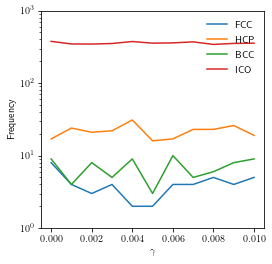

In [379]:
if CommonNeighAnl:
    path = '.'
    sarr = np.loadtxt('%s/StructureTypeCounts.txt'%path)

    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel('Frequency')
    ax.set_ylim(1e0,1e3)
    ax.set_yscale('log')
    #
    #ax.plot(sarr[:,0],sarr[:,1],label='Other')
    ax.plot(sarr[:,0],sarr[:,2],label='FCC')
    ax.plot(sarr[:,0],sarr[:,3],label='HCP')
    ax.plot(sarr[:,0],sarr[:,4],label='BCC')
    ax.plot(sarr[:,0],sarr[:,5],label='ICO')
    #
    ax.legend(frameon=False)
    plt.savefig('StructureTypeGamma.png',dpi=75,bbox_inches='tight')
    plt.show()

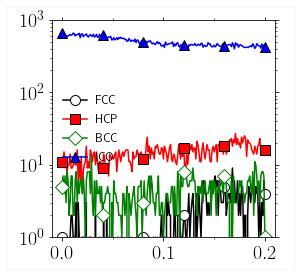

In [389]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e0,1e3)
    
    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    #
    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    sarr  = np.loadtxt('CnaCo5Cr5Fe40Mn27Ni26/Run0/StructureTypeCounts.txt')
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        'FCC','HCP','BCC','ICO'
                                        ],markers, colors, fillstyles, range(10) )):

        #--- fliter
        ydata = sarr[:,indx+2] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/5),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('CrysFracGood.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Crltns with d2min

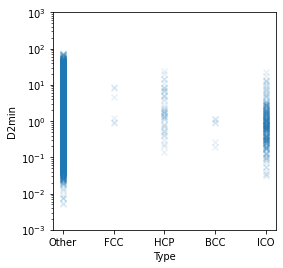

In [124]:
if CommonNeighAnl and DminAnalysis:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Type')
    ax.set_ylabel('D2min')
    ax.set_ylim(1e-3,1e3)
    ax.xaxis.set_ticks([0,1,2,3,4])
    ax.xaxis.set_ticklabels(['Other','FCC','HCP','BCC','ICO'])
    
    ax.set_yscale('log')
    ax.scatter(pd.DataFrame(cna.__dict__).sort_values(by='id')['StructureType'],
                pd.DataFrame(d2min.__dict__).sort_values(by='id')['d2min'],
                alpha = 0.1,
                marker='x'
               )

# Displacement Gradients

## Interpolate Displacements
### cubic grid

In [91]:
#--- mean dist between atoms 
natoms = len( atoms0.x ) 
CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
volume = np.linalg.det( CellVectorOrtho )
dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                 box0.CellVector, 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))


### center box + margin

In [92]:
if StrnAnalysis:
    #--- get a chunk of the full copy
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.2, mode = 'isotropic' )

    points = np.c_[uatoms.xm,uatoms.ym,uatoms.zm][indices] #--- unstructured points
    values = np.c_[uatoms.dx,uatoms.dy,uatoms.dz][indices] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    uintrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','dx','dy','dz']).to_dict(orient='list'))



### Print

In [289]:
if StrnAnalysis:

    file_name = 'uintrp.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    #for itime in df_intrp:
    PrintOvito( pd.DataFrame( uintrp.__dict__ ), 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','dx','dy','dz'] )


## Strain tensor

In [93]:
if StrnAnalysis:
    csn = lp.ComputeStrn( uintrp, box0 )
    csn.Reshape( xlin, ylin, zlin )
    csn.Gradient()
    csn.SetStrn('exy')
    Exy = csn.Get(attrs = ['x','y','z','exy'])


### imshow

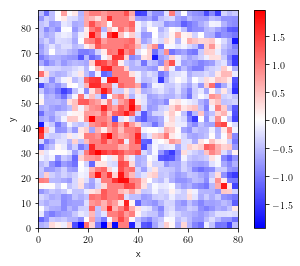

In [96]:
def FilterMatrix( CellVector, CellOrigin,
                  xlin, ylin, zlin,
                  xv, yv, zv ,
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf



if StrnAnalysis:

    #itime = np.max(dfD2min_intrp.keys())
    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[Exy.exy].reshape(((ny,nx,nz)))
    #value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

    # lx=xlin[-1]-xlin[0]
    # ly=ylin[-1]-ylin[0]
    # #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
    # value = np.c_[df_intrp[itime]['ux']]
    # value = value.reshape(((ny,nx,nz)))
    #print value.shape

    #--- filter value
    # value = FilterMatrix( box0.CellVector, box0.CellOrigin,
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )
    #print value.shape
    #print vf.shape

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()
    #val = value[:,:,nz/2].copy()
    #print val.shape

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
               title = 'strain.png',
           )

In [89]:
# fig=plt.figure(figsize=(4,4))
# ax=fig.add_subplot(111)
# ax2=ax.twinx()

# # ax.set_xlim(min(xlin),max(xlin))
# # ax2.set_xlim(min(xlin),max(xlin))
# # ax.set_ylim(-1,1)
# # ax2.set_ylim(-1,1)

# f = val[:,0]
# df=val0[:,0]

# dx=xlin[1]-xlin[0]
# ax.plot(ylin, f,'-o',label='uy')
# #ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
# ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
# #ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
# #ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
# ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


# ax2.legend()
# plt.show()

In [90]:
# itime = np.max(Strain.keys())
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# # value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# # value = value.reshape(((ny,nx,nz)))
# #dvalux = GetDerivX( value,lx )

# #value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
# dvaluy = GetDerivY( value,ly )

# exy=dvaluy
# #--- xy plane
# value0 = exy[:,:,-1].copy()

# PltBitmap(value0, 
#           xlabel = 'x', ylabel = 'y',
#           xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#           zscore = None,
#           frac = 1.0, #--- plot a patch
#         )

### Print

In [30]:
if StrnAnalysis:

    file_name = 'strain.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    # times = Strain.keys()
    # times.sort()
    #--- bulk strain
    dx=box.CellVector[0,1]-box.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1


    PrintOvito( pd.DataFrame(Exy.__dict__), 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exy'] )
    

### Auto-Correlations

In [97]:
if StrnAnalysis:

    #Crltn = {}
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[Exy.exy].reshape((ny,nx,nz))
    #    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
    #    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))

    #--- shuffle
    #     ( nx, ny, nz ) =  value.shape
    #     slist = value.flatten()
    #     np.random.shuffle(slist)
    #     value=slist.reshape((nx, ny, nz))    
        #
    #--- filter value
    #     value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    Crltn = GetAutoCorrelation( value )


### Print

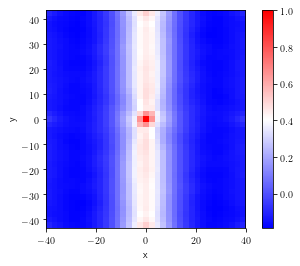

In [99]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    
    crltn = Crltn #[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_strain.%s.png'%itime,
              dpi = 60
            )
        # #--- zx plane
        # val = crltn[0,:,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'x',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )
        # #--- zy plane
        # val = crltn[:,0,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'y',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )



### Crltn Length

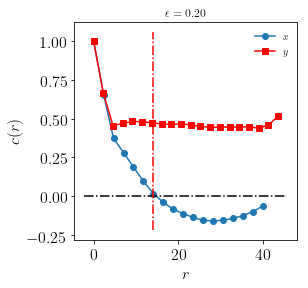

(14.108201970564707, nan)

In [107]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_strain.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    np.savetxt('Cx.txt',np.c_[xdata0.real,ydata0.real],header='x\tc(x)')
    np.savetxt('Cy.txt',np.c_[xdata.real,ydata.real],header='y\tc(y)')

#### multiple plots

In [109]:
# #--- extract length
# ebulk = []
# Xc = []
# Yc = []
# keys = Crltn.keys()
# keys.sort()
# for itime in keys:
#     #--- bulk strain
#     dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#     l1=CellVector[ itime ][1,1]
#     ebulk += [0.5*dx/l1]
    
#     xc, yc = PltCrltnFunc( Crltn[ itime ], 
#                           (xv,yv),
#                           cTOL = 4e-2,
#                           PLOT = None,
#                          )
#     Xc += [xc]
#     Yc += [yc]

# #--- plot
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# xstr = r'$\epsilon$'
# ystr = r'$r_c$'
# ax.set_xlabel(xstr,fontsize=16)
# #ax.set_ylabel(ystr,fontsize=16)
# ax.tick_params(labelsize=16)
# #
# ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
# ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
# ax.legend(frameon=False)
# plt.savefig('rc.png',dpi=75,bbox_inches='tight')
# plt.show()


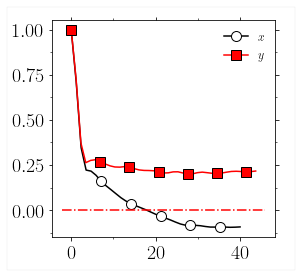

In [201]:
RemoteMachine=None
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 5
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'x','y'
#                                           'CoNiFe',
#                                             'CoNiCrFe',
#                                             'CoCrFeMn',
#                                             'CoNiCrFeMn',
#                                             'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('CrltnFeNi/Run2/C%s.txt'%GlassType,dtype=str)
        #--- fliter
        ydata = list(map(eval,sarr[:,1])) #--- first 2nd col is stress drop
        xdata = list(map(eval,sarr[:,0])) #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black',
                markevery=6,
                label = '$%s$'%GlassType)
    ax.plot(ax.axis()[:2],[0,0],'r-.')

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('cr.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# bar chart

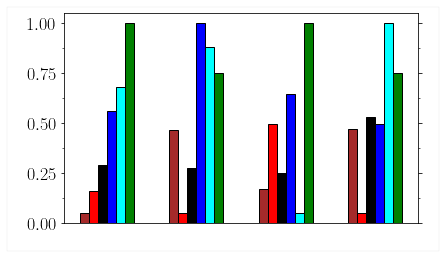

In [284]:
def Scale(d):
    xmin=np.min(list(d.values()))
    xmax=np.max(list(d.values()))
    for key in d:
        x=(d[key]-xmin)/(xmax-xmin)
        d[key]=x if x >0.0 else 0.05

# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)

    fig = plt.figure ()
    ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
#    ax.set_ylim (0,1.1)
    ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
    ax.xaxis.set_minor_locator (AutoMinorLocator (2))
    ax.yaxis.set_minor_locator (AutoMinorLocator (2))

    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    
    #--- store different measurements
    sarr_Mismatch = {}
    sarr_StrsDrop = {}
    sarr_BandWidth = {}
    sarr_Cxy = {}
    for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
                                        'FeNi',
                                         'CoNiFe',
                                          'CoNiCrFe',
                                          'CoCrFeMn',
                                           'CoNiCrFeMn',
                                          'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles,range(20))):

        sarr  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
        sarr_StrsDrop[GlassType]= -np.mean(sarr[:,1][~np.isnan(sarr[:,1])])
        #---
        sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        sarr_BandWidth[GlassType] = np.mean(xdata[~np.isnan(xdata)])
        #---
        sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        sarr_Mismatch[GlassType] = np.mean(sarr[:,0][~np.isnan(sarr[:,0])])
        #---
        cxy=[]
        for irun in range(3):
            try:
                sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
                hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
                #--- fliter
                xdata = sarr[:,1] #--- first 2nd col is stress drop
                cxy.append(np.mean(xdata[-1-8:-1])) #--- mean of the last 10 points
            except:
                continue
        sarr_Cxy[GlassType] = np.mean(cxy)
        
        
    #--- scale
    Scale(sarr_StrsDrop)
    Scale(sarr_BandWidth)
    Scale(sarr_Mismatch)
    Scale(sarr_Cxy)
    
    #--- sort based on a specific measured quantity    
    slist=[[sarr_Mismatch[key],key,colors[indxx]] for key,indxx in zip(sarr_Mismatch,range(32))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
    X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
    X_axis = np.arange(len (X))
    
    #--- plot
    for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):

        ax.bar(X_axis - 0.3+indxx*0.1, 
               [sarr_Mismatch[GlassType],sarr_StrsDrop[GlassType],sarr_BandWidth[GlassType],sarr_Cxy[GlassType]], 
#               [sarr_Cxy[GlassType]], 
               0.1, color =color, edgecolor ='black', label =GlassType)
#    plt.xticks(X_axis, X)
    ax.axes.xaxis.set_visible(False)
#    plt.ylabel("Observables")
#    plt.legend(bbox_to_anchor=(1,1))
    DrawFrame(ax, 0.16,0.06,0.13,0.03,0.04)
    #
    plt.savefig('barchart.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#     plt.show ()

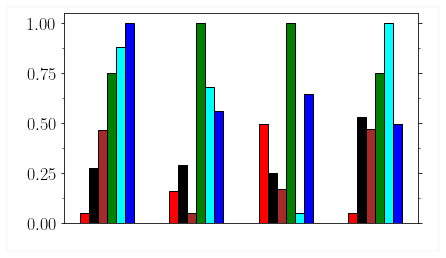

In [39]:
def Scale(d):
    xmin=np.min(list(d.values()))
    xmax=np.max(list(d.values()))
    for key in d:
        x=(d[key]-xmin)/(xmax-xmin)
        d[key]=x if x >0.0 else 0.05

# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)

    fig = plt.figure ()
    ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
#    ax.set_ylim (0,1.1)
    ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
    ax.xaxis.set_minor_locator (AutoMinorLocator (2))
    ax.yaxis.set_minor_locator (AutoMinorLocator (2))

    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    
    #--- store different measurements
    sarr_Mismatch = {}
    sarr_StrsDrop = {}
    sarr_BandWidth = {}
    sarr_Cxy = {}
    for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
                                        'FeNi',
                                         'CoNiFe',
                                          'CoNiCrFe',
                                          'CoCrFeMn',
                                           'CoNiCrFeMn',
                                          'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles,range(20))):

        sarr  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
        sarr_StrsDrop[GlassType]= -np.mean(sarr[:,1][~np.isnan(sarr[:,1])])
        #---
        sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        sarr_BandWidth[GlassType] = np.mean(xdata[~np.isnan(xdata)])
        #---
        sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        sarr_Mismatch[GlassType] = np.mean(sarr[:,0][~np.isnan(sarr[:,0])])
        #---
        cxy=[]
        for irun in range(3):
            try:
                sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
                hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
                #--- fliter
                xdata = sarr[:,1] #--- first 2nd col is stress drop
                cxy.append(np.mean(xdata[-1-8:-1])) #--- mean of the last 10 points
            except:
                continue
        sarr_Cxy[GlassType] = np.mean(cxy)
        
        
    #--- scale
    Scale(sarr_StrsDrop)
    Scale(sarr_BandWidth)
    Scale(sarr_Mismatch)
    Scale(sarr_Cxy)
    
    #--- sort based on a specific measured quantity    
    slist=[[sarr_StrsDrop[key],key,colors[indxx]] for key,indxx in zip(sarr_StrsDrop,range(32))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
    X = ['$h_{min}$','$\delta_a$','$w_{sb}$','$c_{xy}$']
    X_axis = np.arange(len (X))
    
    #--- plot
    for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):

        ax.bar(X_axis - 0.3+indxx*0.1, 
               [sarr_StrsDrop[GlassType],sarr_Mismatch[GlassType],sarr_BandWidth[GlassType],sarr_Cxy[GlassType]], 
#               [sarr_Cxy[GlassType]], 
               0.1, color =color, edgecolor ='black', label =GlassType)
    plt.xticks(X_axis, X)
    ax.axes.xaxis.set_visible(False)
#    plt.ylabel("Observables")
#    plt.legend(bbox_to_anchor=(1,1))
    DrawFrame(ax, 0.16,0.06,0.13,0.03,0.04)
    #
    plt.savefig('barchart.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#     plt.show ()

In [34]:
# RemoteMachine=None

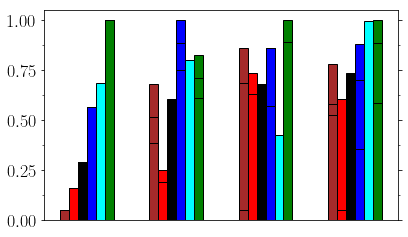

In [277]:
def Scale(d):
#    pdb.set_trace()
    xmin=np.min([item for key in d for item in d[key]]) #list(d.values())#np.min(np.array().flatten())
    xmax=np.max([item for key in d for item in d[key]])
    for key in d:
        x=(np.array(d[key])-xmin)/(xmax-xmin)
        x[x==0.0]=0.05
        d[key]=x #if x >0.0 else 0.05

# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)

    fig = plt.figure ()
    ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
#    ax.set_ylim (0,1.1)
    ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
    ax.xaxis.set_minor_locator (AutoMinorLocator (2))
    ax.yaxis.set_minor_locator (AutoMinorLocator (2))

    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    
    #--- store different measurements
    sarr_Mismatch = {}
    sarr_StrsDrop = {}
    sarr_BandWidth = {}
    sarr_Cxy = {}
    for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
                                        'FeNi',
                                         'CoNiFe',
                                          'CoNiCrFe',
                                          'CoCrFeMn',
                                           'CoNiCrFeMn',
                                          'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles,range(20))):

        sarr  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
        sarr_StrsDrop[GlassType]= -sarr[:,1][~np.isnan(sarr[:,1])]
        #---
        sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        sarr_BandWidth[GlassType] = xdata[~np.isnan(xdata)]
        #---
        sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        sarr_Mismatch[GlassType] = sarr[:,0][~np.isnan(sarr[:,0])]
        #---
        cxy=[]
        for irun in range(3):
            try:
                sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
                hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
                #--- fliter
                xdata = sarr[:,1] #--- first 2nd col is stress drop
                cxy.append(np.mean(xdata[-1-8:-1])) #--- mean of the last 10 points
            except:
                continue
        sarr_Cxy[GlassType] = cxy
        
        
    #--- scale
    Scale(sarr_StrsDrop)
    Scale(sarr_BandWidth)
    Scale(sarr_Mismatch)
    Scale(sarr_Cxy)
    
    #--- sort based on a specific measured quantity    
    slist=[[np.mean(sarr_Mismatch[key]),key,colors[indxx]] for key,indxx in zip(sarr_Mismatch,range(32))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
    X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
    X_axis = np.arange(len (X))
    
    #--- plot
    for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):
        for iprop,prop in zip(range(len(X_axis)),
                              [sarr_Mismatch[GlassType], sarr_StrsDrop[GlassType],sarr_BandWidth[GlassType],sarr_Cxy[GlassType]]): 
            prop=list(prop)
            prop.sort(reverse=True)
            for irun in range(3):
                try:
                    ax.bar([X_axis[iprop] - 0.3+indxx*0.1], [prop[irun]],
                   0.1, color =color, edgecolor ='black', label =GlassType)
                except:
                    continue
#    plt.xticks(X_axis, X)
    ax.axes.xaxis.set_visible(False)
#    plt.ylabel("Observables")
#    plt.legend(bbox_to_anchor=(1,1))
    fig.savefig ("barchart.png",dpi=150)
#     plt.show ()

In [274]:
prop.sort()
list(prop).sort(reverse=True)
prop

array([0.38705091, 0.51432068, 0.68148541])

# Machine learning

## Descriptors

In [839]:
def GetAttribute(df,rbar,sigma):
    Gfunc = lambda x:np.exp(-0.5*((x-rbar)/sigma)**2) #--- x is distance: Eq 5 in Ma et al. Materials Today 40 (2020):
    rho=df.apply(lambda x: Gfunc(x[4]),axis=1) #--- !!!!!!!!!!!! pair-wise density function x[3]=rij
    #---
    tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
    tmp_sum=tmp.groupby(by='id').aggregate(np.sum) #--- atom-wise
    return np.array(tmp_sum['rho'])

if ml:
    #--- voronoi data
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )

    #--- d2min
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )

    #--- atom-wise densities
    df = lmpNeigh.coord_atoms_broken[itime]
#    rbar = 1.0*rpeak #--- density around rbar
#    x = GetAttribute(df,rbar,sigma) #--- attribute vector
    rbars = np.arange(0.6*rpeak,cutoff,sigma) #[2.5,4.0, 5.5, 7.0] #np.arange(0.6*rpeak,cutoff,sigma)
    X=np.array(list(map(lambda x:GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
    #
    assert X.shape[0] == len(vor.x), 'some atoms have no neighbors!'
    print('X.shape=',X.shape)
    
    pd.DataFrame(d2min.__dict__).head()



X.shape= (50688, 4)


### Plot

          0         1         2
0  1.000000  0.338977 -0.373204
1  0.338977  1.000000 -0.230062
2 -0.373204 -0.230062  1.000000


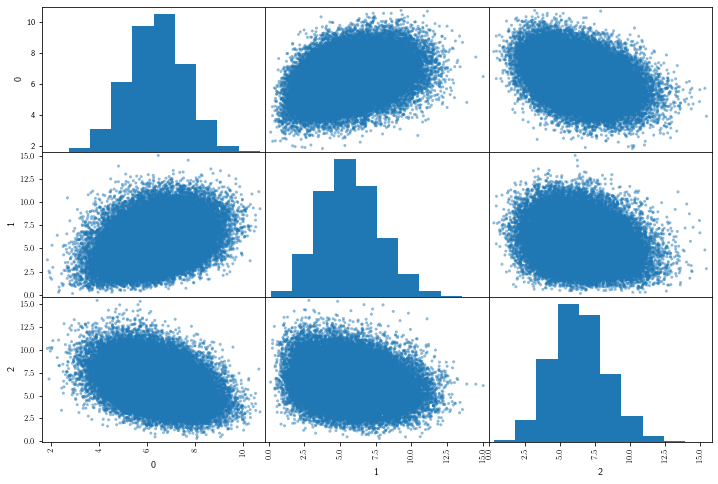

In [867]:
if ml:
    df = pd.DataFrame(X[:,0:3])
    scatter_matrix(df, figsize=(12, 8))
    print(df.corr())
    plt.show()


## Training
### dimensionality reduction

In [861]:
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

if ml:
    #--- data
    y = np.c_[np.log10(d2min.d2min)>=0.57]
    assert X.shape[0] == len(yy)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)


    #--- pipeline
    DimReduc = make_pipeline( 
                              StandardScaler(),
                              TSNE(n_components=2,random_state=0),
#                              PCA(n_components=2, random_state=0),
        
                            )
    DimReduc.fit(X_train)
    X_embedded = DimReduc.fit_transform(X_train)

#print(DimReduc.named_steps['tsne'].explained_variance_ratio_)
            


AttributeError: 'TSNE' object has no attribute 'explained_variance_ratio_'

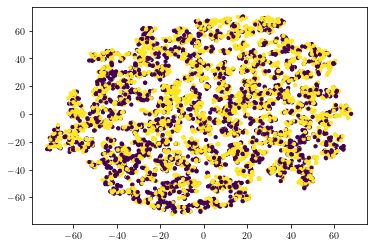

In [863]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=10,c=y_train)
plt.show()

### regression/classification

In [ ]:
if ml:
    regr = make_pipeline( 
                          StandardScaler(),
#                          LinearSVR(random_state=0, tol=1e-5,C=1.0,epsilon=.1*np.std(yy)),
#                          LinearSVC(random_state=0, tol=1e-5 ),
#                          LinearRegression(),
                        )
    #--- fit
    regr.fit(xx, yy)
    #--- print
    for key in ['linearsvc']:#regr.named_steps:
#        if 1:
        try:
            #--- mse
            y_true = yy.flatten()
            y_pred = regr.named_steps[key].predict(xx)
            mse = mean_squared_error(y_true*1, y_pred*1)
            #--- print
            print(key,':','coeffs=',regr.named_steps[key].coef_,'mse=',mse)
        except:
            traceback.print_exc()
            continue


## Prediction

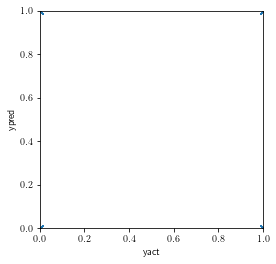

In [835]:
if ml:
    fig = plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    #
    ax.set_xlabel('yact')
    ax.set_ylabel('ypred')
    #
    ax.axis([yy.min(),yy.max(),yy.min(),yy.max()])
    #
    ax.scatter(yy,regr.predict(xx),marker='x',alpha=0.1)
    #
    plt.show()

In [414]:
# def Validate(x,y,C=range(0,40,10),cv_samples=10):
#     mse={}
#     for c in C:
# #    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
#         try:
#             regr = make_pipeline( StandardScaler(),
#                       LinearSVR(random_state=0, tol=1e-5, C=c))
#             regr.fit(x, y)
# #            transfrm = ReturnShapeFunc(x,df)
#             #--- vadidate    
#             scores = cross_validate(reg,  x, y, cv=cv_samples,
#                                          scoring=('r2', 'neg_mean_squared_error'),
#                                          return_train_score=True)
#             mse[c] = np.mean(scores['train_neg_mean_squared_error'])
#         except:
#             continue
#     return mse

# if ml:
#     mse = Validate(X,np.c_[y],C=np.logspace(-3,2,6)) #[0.1,1.0,10.0])



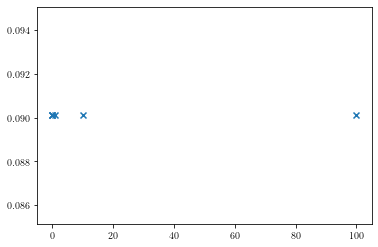

{0.001: -0.09010491853015593,
 0.01: -0.09010491853015593,
 0.1: -0.09010491853015593,
 1.0: -0.09010491853015593,
 10.0: -0.09010491853015593,
 100.0: -0.09010491853015593}

In [415]:
# if ml:
#     try:
#         keys=mse.keys()
#         plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#     #    plt.yscale('log')
#     #    plt.xscale('log')
#     #    plt.ylim(1e-5,1e-2)
#         plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#         plt.show()
#     except:
#         pass
#     mse

In [396]:
# from sklearn.datasets import make_regression
# X, y = make_regression(n_features=1, random_state=0)
# X+=10
# X*=2
# y-=40
# y/=2
# plt.scatter(X,y)
# plt.show()